# Install Library

In [ ]:
!pip install nltk
!pip install gensim
!pip install spacy
!python -m spacy download en_core_web_sm

# Import Library

In [2]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from google.colab import drive
from tqdm import tqdm

In [3]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Import Data Train

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Bitcoin_Tweet.csv'
data = pd.read_csv(path, sep=',')
data

user_name    user_location  \
0                                 DeSota Wilson      Atlanta, GA   
1                                      CryptoND              NaN   
2                                     Tdlmatias  London, England   
3                          Crypto is the future              NaN   
4      Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader           Europa   
...                                         ...              ...   
48578                                   Jonbull    New York, USA   
48579                                  BTCtoCAD           Canada   
48580                                   PiRoyot              NaN   
48581                                    Neozul        Milky way   
48582                            BitcoinTracker              NaN   

                                        user_description         user_created  \
0      Biz Consultant, real estate, fintech, startups...  2009-04-26 20:05:09   
1      😎 BITCOINLIVE is a Dutch platform aimed at inf...  2019-10-17 20:12:10   
2      IM Academy : The best #forex, #SelfEducation, ...  2014-11-10 10:50:37   
3      I will post a lot of buying signals for BTC tr...  2019-09-28 16:48:12   
4      Co-founder @RENJERJerky | Forbes 30Under30 | I...  2016-02-03 13:15:55   
...                                                  ...                  ...   
48578  Author of the book Jonbull's Stock Guide @Guid...  2010-03-15 03:38:08   
48579  #Bitcoin Is King 👑\nBitcoin(BTC) to Canadian D...  2020-07-29 01:50:02   
48580                            Test Twitter Bot for Pi  2020-06-07 10:46:59   
48581                    #crypto #bitcoin #ethereum #ICT  2009-05-18 17:40:53   
48582  Tracking Bitcoin Prices and Moving Averages wi...  2021-02-17 21:05:57   

       user_followers  user_friends  user_favourites  user_verified  \
0                8534          7605             4838          False   
1                6769          1532            25483          False   
2                 128           332              924          False   
3                 625           129               14          False   
4                1249          1472            10482          False   
...               ...           ...              ...            ...   
48578            2787          4275             6300          False   
48579             201            30              146          False   
48580               5             0                0          False   
48581             226           461             1299          False   
48582              54             8                8          False   

                      date                                               text  \
0      2021-02-10 23:59:04  Blue Ridge Bank shares halted by NYSE after #b...   
1      2021-02-10 23:58:48  😎 Today, that's this #Thursday, we will do a "...   
2      2021-02-10 23:54:48  Guys evening, I have read this article about B...   
3      2021-02-10 23:54:33  $BTC A big chance in a billion! Price: \487264...   
4      2021-02-10 23:54:06  This network is secured by 9 508 nodes as of t...   
...                    ...                                                ...   
48578  2021-03-11 22:30:23  Bill Gates advised against investing in #Bitco...   
48579  2021-03-11 22:30:04  #Bitcoin price in US Dollar #BTC $usd #BTCUSD ...   
48580  2021-03-11 22:30:02  Market Id : BTC-AUD\nLast Price :74260.91\n24 ...   
48581  2021-03-11 22:29:39    Bitcoin retesting ATH ❤️\n#Bitcoin #btc #Crypto   
48582  2021-03-11 22:29:38  $BTCUSD\nCurrent Bitcoin Price: $57,908\nDay H...   

                                        hashtags               source  \
0                                    ['bitcoin']      Twitter Web App   
1      ['Thursday', 'Btc', 'wallet', 'security']  Twitter for Android   
2                                            NaN      Twitter Web App   
3             ['Bitcoin', 'FX', 'BTC', 'crypto']              dlvr.it   
4                                        ['BTC']      Twi

In [ ]:
data = data.drop(columns=['user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'hashtags', 'is_retweet','source'])
data.head()

user_name                 date  \
0                             DeSota Wilson  2021-02-10 23:59:04   
1                                  CryptoND  2021-02-10 23:58:48   
2                                 Tdlmatias  2021-02-10 23:54:48   
3                      Crypto is the future  2021-02-10 23:54:33   
4  Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader  2021-02-10 23:54:06   

                                                text  
0  Blue Ridge Bank shares halted by NYSE after #b...  
1  😎 Today, that's this #Thursday, we will do a "...  
2  Guys evening, I have read this article about B...  
3  $BTC A big chance in a billion! Price: \487264...  
4  This network is secured by 9 508 nodes as of t...

# Drop Duplicate and Null Data

In [ ]:
duplicated_data = data[data.duplicated(subset=['text'], keep=False)]
num_duplicates = duplicated_data.shape[0]  # Jumlah baris dari data yang terduplikasi
print("Jumlah data yang terduplikasi:", num_duplicates)

null_data = data[data['text'].isnull()]
num_nulls = null_data.shape[0]  # Jumlah baris dari data yang masih null
print("\nJumlah data yang masih null:", num_nulls)

Jumlah data yang terduplikasi: 475

Jumlah data yang masih null: 0


In [ ]:
data.drop_duplicates(subset=['text'], inplace=True)
data['text'].duplicated().sum()

0

In [ ]:
data.dropna(subset=['text'], inplace=True)
data['text'].isnull().sum()

0

# Cleaning Dataset

In [ ]:
import re

def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)  # Hapus URL
        text = re.sub(r'\s+', ' ', text)  # Hapus spasi berlebihan
        text = re.sub(r':[^:]+:', '', text)  # Hapus emoji
        text = re.sub(r'\W+', ' ', text)  # Hapus hashtag
        text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Hapus mention
        text = re.sub(r'[^A-Za-z\s]', '', text)  # Hapus karakter selain huruf dan spasi
        return text.strip().lower()
    else:
        return ''

data['Cleaned_Text'] = data['text'].apply(clean_text)
data['Cleaned_Text']

0        blue ridge bank shares halted by nyse after bi...
1        today that s this thursday we will do a take  ...
2        guys evening i have read this article about bt...
3        btc a big chance in a billion price bitcoin fx...
4        this network is secured by   nodes as of today...
                               ...                        
48578    bill gates advised against investing in bitcoi...
48579    bitcoin price in us dollar btc usd btcusd xbt ...
48580      market id    hour high   best bid   btc bitcoin
48581             bitcoin retesting ath bitcoin btc crypto
48582    btcusd current bitcoin price   day low   year ...
Name: Cleaned_Text, Length: 48345, dtype: object

In [ ]:
nltk.download('punkt')

def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

data['Tokenization'] = data['Cleaned_Text'].apply(tokenize_text)
data['Tokenization']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


0        [blue, ridge, bank, shares, halted, by, nyse, ...
1        [today, that, s, this, thursday, we, will, do,...
2        [guys, evening, i, have, read, this, article, ...
3        [btc, a, big, chance, in, a, billion, price, b...
4        [this, network, is, secured, by, nodes, as, of...
                               ...                        
48578    [bill, gates, advised, against, investing, in,...
48579    [bitcoin, price, in, us, dollar, btc, usd, btc...
48580    [market, id, hour, high, best, bid, btc, bitcoin]
48581      [bitcoin, retesting, ath, bitcoin, btc, crypto]
48582    [btcusd, current, bitcoin, price, day, low, ye...
Name: Tokenization, Length: 48345, dtype: object

# Stop Word Removal

In [ ]:
nltk.download('stopwords')

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))

    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

data['Stopwords'] = data['Tokenization'].apply(remove_stopwords)
data['Stopwords']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0        [blue, ridge, bank, shares, halted, nyse, bitc...
1        [today, thursday, take, friend, leowandersleb,...
2        [guys, evening, read, article, btc, would, lik...
3        [btc, big, chance, billion, price, bitcoin, fx...
4        [network, secured, nodes, today, soon, biggest...
                               ...                        
48578    [bill, gates, advised, investing, bitcoin, say...
48579    [bitcoin, price, us, dollar, btc, usd, btcusd,...
48580    [market, id, hour, high, best, bid, btc, bitcoin]
48581      [bitcoin, retesting, ath, bitcoin, btc, crypto]
48582    [btcusd, current, bitcoin, price, day, low, ye...
Name: Stopwords, Length: 48345, dtype: object

# Lemmatized Data

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_tokens(tokens):
    pos_tags = nltk.pos_tag(tokens)
    pos_tags = [(token, get_wordnet_pos(pos_tag)) for token, pos_tag in pos_tags]
    return [lemmatizer.lemmatize(token, pos=pos_tag) for token, pos_tag in pos_tags]

data['Lemmatized'] = data['Stopwords'].apply(lemmatize_tokens)
data['End_Text'] = data['Lemmatized'].apply(lambda x: ' '.join(x))

In [ ]:
data['Lemmatized']

0        [blue, ridge, bank, share, halt, nyse, bitcoin...
1        [today, thursday, take, friend, leowandersleb,...
2        [guy, even, read, article, btc, would, like, s...
3        [btc, big, chance, billion, price, bitcoin, fx...
4        [network, secure, node, today, soon, big, bear...
                               ...                        
48578    [bill, gate, advise, invest, bitcoin, say, cry...
48579    [bitcoin, price, u, dollar, btc, usd, btcusd, ...
48580    [market, id, hour, high, best, bid, btc, bitcoin]
48581      [bitcoin, retesting, ath, bitcoin, btc, crypto]
48582    [btcusd, current, bitcoin, price, day, low, ye...
Name: Lemmatized, Length: 48345, dtype: object

# Export Data Cleaning

In [ ]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/Dataset (1)/Bitcoin_Tweet(Clean).csv', index=False)

In [ ]:
tqdm.pandas()

path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Bitcoin_Tweet(Clean).csv'
data = pd.read_csv(path)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].str.replace("'", '')

data.to_csv(path, index=False)

data.progress_apply(lambda row: row, axis=1)

100%|██████████| 48236/48236 [00:02<00:00, 20329.17it/s]


user_name                 date  \
0                                 DeSota Wilson  2021-02-10 23:59:04   
1                                      CryptoND  2021-02-10 23:58:48   
2                                     Tdlmatias  2021-02-10 23:54:48   
3                          Crypto is the future  2021-02-10 23:54:33   
4      Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader  2021-02-10 23:54:06   
...                                         ...                  ...   
48231                                   Jonbull  2021-03-11 22:30:23   
48232                                  BTCtoCAD  2021-03-11 22:30:04   
48233                                   PiRoyot  2021-03-11 22:30:02   
48234                                    Neozul  2021-03-11 22:29:39   
48235                            BitcoinTracker  2021-03-11 22:29:38   

                                                    text  \
0      Blue Ridge Bank shares halted by NYSE after #b...   
1      😎 Today, thats this #Thursday, we will do a "🎬...   
2      Guys evening, I have read this article about B...   
3      $BTC A big chance in a billion! Price: \487264...   
4      This network is secured by 9 508 nodes as of t...   
...                                                  ...   
48231  Bill Gates advised against investing in #Bitco...   
48232  #Bitcoin price in US Dollar #BTC $usd #BTCUSD ...   
48233  Market Id : BTC-AUD\nLast Price :74260.91\n24 ...   
48234    Bitcoin retesting ATH ❤️\n#Bitcoin #btc #Crypto   
48235  $BTCUSD\nCurrent Bitcoin Price: $57,908\nDay H...   

                                            Cleaned_Text  \
0      blue ridge bank shares halted by nyse after bi...   
1      today that s this thursday we will do a take  ...   
2      guys evening i have read this article about bt...   
3      btc a big chance in a billion price bitcoin fx...   
4      this network is secured by   nodes as of today...   
...                                                  ...   
48231  bill gates advised against investing in bitcoi...   
48232  bitcoin price in us dollar btc usd btcusd xbt ...   
48233    market id    hour high   best bid   btc bitcoin   
48234           bitcoin retesting ath bitcoin btc crypto   
48235  btcusd current bitcoin price   day low   year ...   

                                            Tokenization  \
0      [blue, ridge, bank, shares, halted, by, nyse, ...   
1      [today, that, s, this, thursday, we, will, do,...   
2      [guys, evening, i, have, read, this, article, ...   
3      [btc, a, big, chance, in, a, billion, price, b...   
4      [this, network, is, secured, by, nodes, as, of...   
...                                                  ...   
48231  [bill, gates, advised, against, investing, in,...   
48232  [bitcoin, price, in, us, dollar, btc, usd, btc...   
48233  [market, id, hour, high, best, bid, btc, bitcoin]   
48234    [bitcoin, retesting, ath, bitcoin, btc, crypto]   
48235  [btcusd, current, bitcoin, price, day, low, ye...   

                                               Stopwords  \
0      [blue, ridge, bank, shares, halted, nyse, bitc...   
1      [today, thursday, take, friend, leowandersleb,...   
2      [guys, evening, read, article, btc, would, lik...   
3      [btc, big, chance, billion, price, bitcoin, fx...   
4      [network, secured, nodes, today, soon, biggest...   
...                                                  ...   
48231  [bill, gates, advised, investing, bitcoin, say...   
48232  [bitcoin, price, us, dollar, btc, usd, btcusd,...   
48233  [market, id, hour, high, best, bid, btc, bitcoin]   
48234    [bitcoin, retesting, ath, bitcoin, btc, crypto]   
48235  [btcusd, current, bitcoin, price, day, low, ye...   

                                              Lemmatized  \
0      [blue, ridge, bank, share, halt, nyse, bitcoin...   
1      [today, thursday, take, friend, leowandersleb,...   
2      [guy, even, read, article, btc, would, like, s...   
3      [btc, big, chance, billion, price, bitcoin

# Label Sentiment

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

bitcoin_lexicon = {
    'blockchain': 3, 'digital gold': 3, 'decentralization': 3, 'halving': 3, 'mining': 2, 'hashrate': 1, 'proof of work': 2, 'lightning network': 3, 'SegWit': 2,
    'Taproot': 2, 'wallet': 3, 'cold storage': 3, 'hardware wallet': 3, 'paper wallet': 3, 'multi-signature wallet': 3, 'DYOR': 2, 'ATH': 2, 'all-time high': 2, 'hodl': 2,
    'moon': 3, 'bull run': 3, 'BUIDL': 3, 'dump': 3, 'regulatory clarity': 2, 'institutional adoption': 3, 'ETF': 2, 'futures': 2, 'options': 2,
    'maximalism': 2, 'Lightning Network adoption': 3, 'scaling solutions': 2, 'layer 2 solutions': 2, 'privacy features': 2, 'financial sovereignty': 3,
    'adoption': 3, 'conference': 2, 'whitepaper': 2, 'improvement proposal': 2, 'mining centralization': -3, '51% attack': -4, 'double-spending': -3, 'scalability': -3,
    'transaction fees': -2, 'energy consumption': -3, 'environmental concerns': -3, 'carbon footprint': -3, 'regulation': -3, 'ban': -4, 'block reward': 2,
    'crackdown': -4, 'scam': -6, 'theft': -6, 'fraud': -6, 'bubble': -5, 'crash': -5, 'volatility': -3, 'price manipulation': -4, 'whale manipulation': -4, 'pump and dump': -7,
    'market manipulation': -5, 'REKT': -6, 'bagholder': -4, 'shill': -3, 'bullish': 3.0, 'bearish': -3.0, 'profit': 2.7, 'loss': -2.7, 'volatile': -1.6,
    'up': 2.6, 'down': -2.6, 'bull run': 2.9, 'bubble': -1.9, 'rally': 2.8, 'dip': -2.8, 'stable': 1.4, 'positive': 1.5, 'negative': -1.5, 'overvalued': -2.6,
    'promising': 2.7, 'uncertain': -2.7, 'profitable': 2.6, 'risky': -2.6, 'bull': 3.0, 'bear': -3.0, 'boom': 2.7, 'fud': -2.7, 'green': 2.5, 'red': -2.5, 'recovery': 2.6,
    'crisis': -2.6, 'speculative': -1.5, 'downtrend': -2.7, 'uptrend': 2.7, 'gains': 2.6, 'decline': -2.6, 'bullish trend': 2.8, 'bearish trend': -2.8,
    'volatile market': -2.7, 'positive outlook': 2.6, 'negative outlook': -2.6, 'hope': 2.6, 'fear': -2.6, 'fear of missing out': 2.8, 'fomo': 2.8, 'crypto adoption': 2.7,
    'regulation': -2.7, 'opportunity': 2.6, 'uncertainty': -2.6, 'bull market': 3.0, 'bear market': -3.0, 'breakout': 2.7, 'support level': 1.6,
    'resistance level': -1.6, 'thriving': 1.6, 'struggling': -1.6, 'buying pressure': 2.7, 'selling pressure': -2.7, 'rebound': 1.6, 'plunge': -1.6
}

analyzer.lexicon.update(bitcoin_lexicon)

data = data.dropna(subset=['End_Text'])

# Terapkan sentiment analysis
data['Sentiment_Polarity'] = data['End_Text'].apply(analyzer.polarity_scores)

# Ambil nilai sentimen positif, negatif, netral, dan compound
data['Sentiment_Positive'] = data['Sentiment_Polarity'].apply(lambda scores: scores['pos'])
data['Sentiment_Negative'] = data['Sentiment_Polarity'].apply(lambda scores: scores['neg'])
data['Sentiment_Neutral'] = data['Sentiment_Polarity'].apply(lambda scores: scores['neu'])
data['Sentiment_Compound'] = data['Sentiment_Polarity'].apply(lambda scores: scores['compound'])

# Tentukan sentimen berdasarkan nilai compound
data['Sentiment_Vader'] = data['Sentiment_Compound'].apply(lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral'))
data['Sentiment_Score'] = data['Sentiment_Compound'].apply(lambda score: 1 if score > 0 else (0 if score < 0 else 2))

data

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


user_name                 date  \
0                                 DeSota Wilson  2021-02-10 23:59:04   
1                                      CryptoND  2021-02-10 23:58:48   
2                                     Tdlmatias  2021-02-10 23:54:48   
3                          Crypto is the future  2021-02-10 23:54:33   
4      Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader  2021-02-10 23:54:06   
...                                         ...                  ...   
48231                                   Jonbull  2021-03-11 22:30:23   
48232                                  BTCtoCAD  2021-03-11 22:30:04   
48233                                   PiRoyot  2021-03-11 22:30:02   
48234                                    Neozul  2021-03-11 22:29:39   
48235                            BitcoinTracker  2021-03-11 22:29:38   

                                                    text  \
0      Blue Ridge Bank shares halted by NYSE after #b...   
1      😎 Today, thats this #Thursday, we will do a "🎬...   
2      Guys evening, I have read this article about B...   
3      $BTC A big chance in a billion! Price: \487264...   
4      This network is secured by 9 508 nodes as of t...   
...                                                  ...   
48231  Bill Gates advised against investing in #Bitco...   
48232  #Bitcoin price in US Dollar #BTC $usd #BTCUSD ...   
48233  Market Id : BTC-AUD\nLast Price :74260.91\n24 ...   
48234    Bitcoin retesting ATH ❤️\n#Bitcoin #btc #Crypto   
48235  $BTCUSD\nCurrent Bitcoin Price: $57,908\nDay H...   

                                            Cleaned_Text  \
0      blue ridge bank shares halted by nyse after bi...   
1      today that s this thursday we will do a take  ...   
2      guys evening i have read this article about bt...   
3      btc a big chance in a billion price bitcoin fx...   
4      this network is secured by   nodes as of today...   
...                                                  ...   
48231  bill gates advised against investing in bitcoi...   
48232  bitcoin price in us dollar btc usd btcusd xbt ...   
48233    market id    hour high   best bid   btc bitcoin   
48234           bitcoin retesting ath bitcoin btc crypto   
48235  btcusd current bitcoin price   day low   year ...   

                                            Tokenization  \
0      [blue, ridge, bank, shares, halted, by, nyse, ...   
1      [today, that, s, this, thursday, we, will, do,...   
2      [guys, evening, i, have, read, this, article, ...   
3      [btc, a, big, chance, in, a, billion, price, b...   
4      [this, network, is, secured, by, nodes, as, of...   
...                                                  ...   
48231  [bill, gates, advised, against, investing, in,...   
48232  [bitcoin, price, in, us, dollar, btc, usd, btc...   
48233  [market, id, hour, high, best, bid, btc, bitcoin]   
48234    [bitcoin, retesting, ath, bitcoin, btc, crypto]   
48235  [btcusd, current, bitcoin, price, day, low, ye...   

                                               Stopwords  \
0      [blue, ridge, bank, shares, halted, nyse, bitc...   
1      [today, thursday, take, friend, leowandersleb,...   
2      [guys, evening, read, article, btc, would, lik...   
3      [btc, big, chance, billion, price, bitcoin, fx...   
4      [network, secured, nodes, today, soon, biggest...   
...                                                  ...   
48231  [bill, gates, advised, investing, bitcoin, say...   
48232  [bitcoin, price, us, dollar, btc, usd, btcusd,...   
48233  [market, id, hour, high, best, bid, btc, bitcoin]   
48234    [bitcoin, retesting, ath, bitcoin, btc, crypto]   
48235  [btcusd, current, bitcoin, price, day, low, ye...   

                                              Lemmatized  \
0      [blue, ridge, bank, share, halt, nyse, bitcoin...   
1      [today, thursday, take, friend, leowandersleb,...   
2      [guy, even, read, article, btc, would, like, s...   
3      [btc, big, chance, billion, price, bitcoin

In [ ]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/Bitcoin_Tweet(Clean).csv', index=False)

In [53]:
tqdm.pandas()

path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Bitcoin_Tweet(Clean).csv'
data = pd.read_csv(path)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].str.replace("'", '')

data.to_csv(path, index=False)

data.progress_apply(lambda row: row, axis=1)

100%|██████████| 48236/48236 [00:02<00:00, 20073.54it/s]


user_name                 date  \
0                                 DeSota Wilson  2021-02-10 23:59:04   
1                                      CryptoND  2021-02-10 23:58:48   
2                                     Tdlmatias  2021-02-10 23:54:48   
3                          Crypto is the future  2021-02-10 23:54:33   
4      Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader  2021-02-10 23:54:06   
...                                         ...                  ...   
48231                                   Jonbull  2021-03-11 22:30:23   
48232                                  BTCtoCAD  2021-03-11 22:30:04   
48233                                   PiRoyot  2021-03-11 22:30:02   
48234                                    Neozul  2021-03-11 22:29:39   
48235                            BitcoinTracker  2021-03-11 22:29:38   

                                                    text  \
0      Blue Ridge Bank shares halted by NYSE after #b...   
1      😎 Today, thats this #Thursday, we will do a "🎬...   
2      Guys evening, I have read this article about B...   
3      $BTC A big chance in a billion! Price: \487264...   
4      This network is secured by 9 508 nodes as of t...   
...                                                  ...   
48231  Bill Gates advised against investing in #Bitco...   
48232  #Bitcoin price in US Dollar #BTC $usd #BTCUSD ...   
48233  Market Id : BTC-AUD\nLast Price :74260.91\n24 ...   
48234    Bitcoin retesting ATH ❤️\n#Bitcoin #btc #Crypto   
48235  $BTCUSD\nCurrent Bitcoin Price: $57,908\nDay H...   

                                            Cleaned_Text  \
0      blue ridge bank shares halted by nyse after bi...   
1      today that s this thursday we will do a take  ...   
2      guys evening i have read this article about bt...   
3      btc a big chance in a billion price bitcoin fx...   
4      this network is secured by   nodes as of today...   
...                                                  ...   
48231  bill gates advised against investing in bitcoi...   
48232  bitcoin price in us dollar btc usd btcusd xbt ...   
48233    market id    hour high   best bid   btc bitcoin   
48234           bitcoin retesting ath bitcoin btc crypto   
48235  btcusd current bitcoin price   day low   year ...   

                                            Tokenization  \
0      [blue, ridge, bank, shares, halted, by, nyse, ...   
1      [today, that, s, this, thursday, we, will, do,...   
2      [guys, evening, i, have, read, this, article, ...   
3      [btc, a, big, chance, in, a, billion, price, b...   
4      [this, network, is, secured, by, nodes, as, of...   
...                                                  ...   
48231  [bill, gates, advised, against, investing, in,...   
48232  [bitcoin, price, in, us, dollar, btc, usd, btc...   
48233  [market, id, hour, high, best, bid, btc, bitcoin]   
48234    [bitcoin, retesting, ath, bitcoin, btc, crypto]   
48235  [btcusd, current, bitcoin, price, day, low, ye...   

                                               Stopwords  \
0      [blue, ridge, bank, shares, halted, nyse, bitc...   
1      [today, thursday, take, friend, leowandersleb,...   
2      [guys, evening, read, article, btc, would, lik...   
3      [btc, big, chance, billion, price, bitcoin, fx...   
4      [network, secured, nodes, today, soon, biggest...   
...                                                  ...   
48231  [bill, gates, advised, investing, bitcoin, say...   
48232  [bitcoin, price, us, dollar, btc, usd, btcusd,...   
48233  [market, id, hour, high, best, bid, btc, bitcoin]   
48234    [bitcoin, retesting, ath, bitcoin, btc, crypto]   
48235  [btcusd, current, bitcoin, price, day, low, ye...   

                                              Lemmatized  \
0      [blue, ridge, bank, share, halt, nyse, bitcoin...   
1      [today, thursday, take, friend, leowandersleb,...   
2      [guy, even, read, article, btc, would, like, s...   
3      [btc, big, chance, billion, price, bitcoin

In [54]:
format=data[['text', 'Cleaned_Text', 'Sentiment_Vader']]
format

text  \
0      Blue Ridge Bank shares halted by NYSE after #b...   
1      😎 Today, thats this #Thursday, we will do a "🎬...   
2      Guys evening, I have read this article about B...   
3      $BTC A big chance in a billion! Price: \487264...   
4      This network is secured by 9 508 nodes as of t...   
...                                                  ...   
48231  Bill Gates advised against investing in #Bitco...   
48232  #Bitcoin price in US Dollar #BTC $usd #BTCUSD ...   
48233  Market Id : BTC-AUD\nLast Price :74260.91\n24 ...   
48234    Bitcoin retesting ATH ❤️\n#Bitcoin #btc #Crypto   
48235  $BTCUSD\nCurrent Bitcoin Price: $57,908\nDay H...   

                                            Cleaned_Text Sentiment_Vader  
0      blue ridge bank shares halted by nyse after bi...        positive  
1      today that s this thursday we will do a take  ...        positive  
2      guys evening i have read this article about bt...        positive  
3      btc a big chance in a billion price bitcoin fx...        positive  
4      this network is secured by   nodes as of today...        negative  
...                                                  ...             ...  
48231  bill gates advised against investing in bitcoi...        negative  
48232  bitcoin price in us dollar btc usd btcusd xbt ...         neutral  
48233    market id    hour high   best bid   btc bitcoin        positive  
48234           bitcoin retesting ath bitcoin btc crypto         neutral  
48235  btcusd current bitcoin price   day low   year ...        negative  

[48236 rows x 3 columns]

# Data Exploration dan Visualization

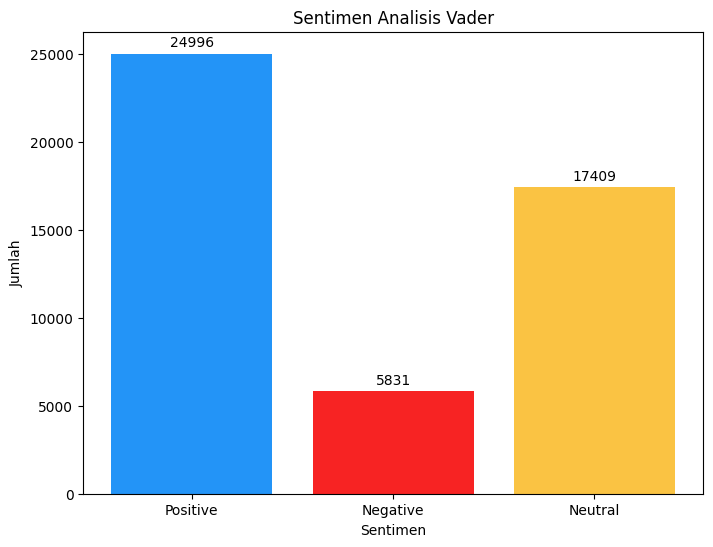

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

positive = data['Sentiment_Vader'].value_counts().get('positive', 0)
negative = data['Sentiment_Vader'].value_counts().get('negative', 0)
neutral = data['Sentiment_Vader'].value_counts().get('neutral', 0)

labels = ['Positive', 'Negative', 'Neutral']
counts = [positive, negative, neutral]

def show_bar_chart(labels, counts, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(labels, counts, color=['#2394f7', '#f72323', '#fac343'])

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.set_title(title)
    ax.set_xlabel('Sentimen')
    ax.set_ylabel('Jumlah')
    plt.show()

show_bar_chart(labels, counts, "Sentimen Analisis Vader")

**World Cloud Positif**

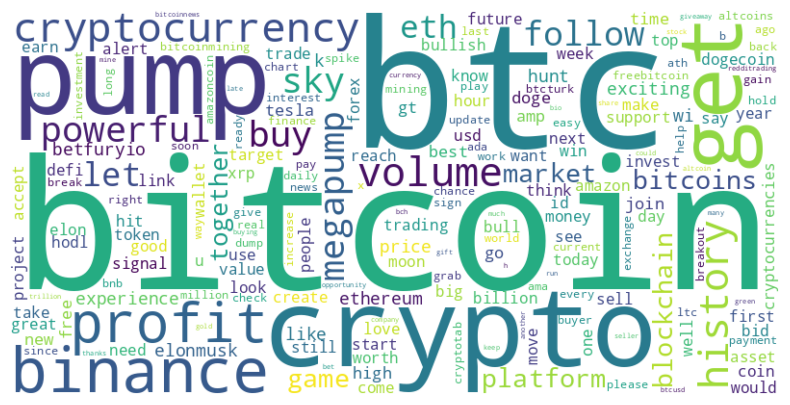

In [56]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

data['End_Text'] = data['End_Text'].astype(str)
word_counts = Counter()
for text in data['End_Text']:
    words = text.split()
    word_counts.update(words)

# Filter kata-kata dengan sentimen positif
positive_words = ' '.join(data[data['Sentiment_Vader'] == 'positive']['End_Text'])

# Hitung frekuensi kata-kata dengan sentimen positif
positive_word_counts = Counter(positive_words.split())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


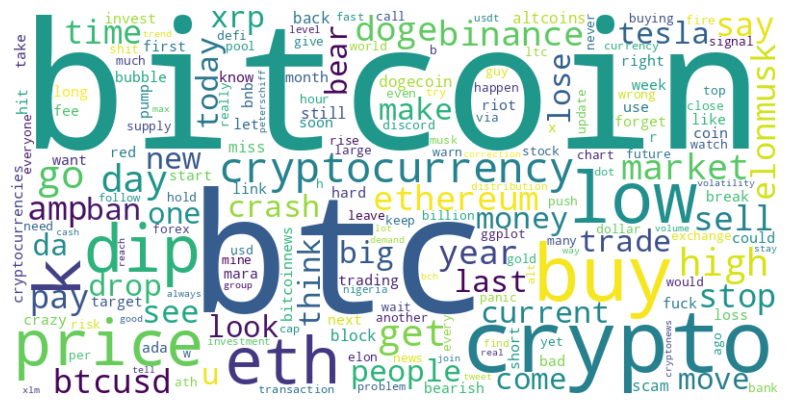

In [57]:
from collections import Counter

data['End_Text'] = data['End_Text'].astype(str)
word_counts = Counter()
for text in data['End_Text']:
    words = text.split()
    word_counts.update(words)

# Filter kata-kata dengan sentimen positif
positive_words = ' '.join(data[data['Sentiment_Vader'] == 'negative']['End_Text'])

# Hitung frekuensi kata-kata dengan sentimen positif
positive_word_counts = Counter(positive_words.split())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


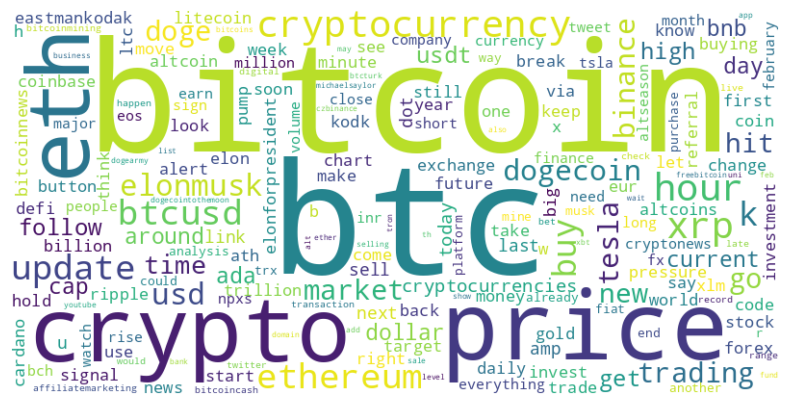

In [58]:
from collections import Counter

data['End_Text'] = data['End_Text'].astype(str)
word_counts = Counter()
for text in data['End_Text']:
    words = text.split()
    word_counts.update(words)

# Filter kata-kata dengan sentimen positif
positive_words = ' '.join(data[data['Sentiment_Vader'] == 'neutral']['End_Text'])

# Hitung frekuensi kata-kata dengan sentimen positif
positive_word_counts = Counter(positive_words.split())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Feature Engineering

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['End_Text'], data['Sentiment_Vader'], test_size=0.2, random_state=42)

In [61]:
print("Jumlah hasil sentimen pada data latih:")
print(y_train.value_counts())

# Melihat jumlah hasil sentimen pada data uji
print("\nJumlah hasil sentimen pada data uji:")
print(y_test.value_counts())

Jumlah hasil sentimen pada data latih:
Sentiment_Vader
positive    19927
neutral     13956
negative     4705
Name: count, dtype: int64

Jumlah hasil sentimen pada data uji:
Sentiment_Vader
positive    5069
neutral     3453
negative    1126
Name: count, dtype: int64


In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

print(f"Dimensi fitur dari data latih: {X_train_features.shape}")
print(f"Dimensi fitur dari data uji: {X_test_features.shape}")

Dimensi fitur dari data latih: (38588, 20442)
Dimensi fitur dari data uji: (9648, 20442)


# Balanced Distribution Smote

In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto')
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_features, y_train)

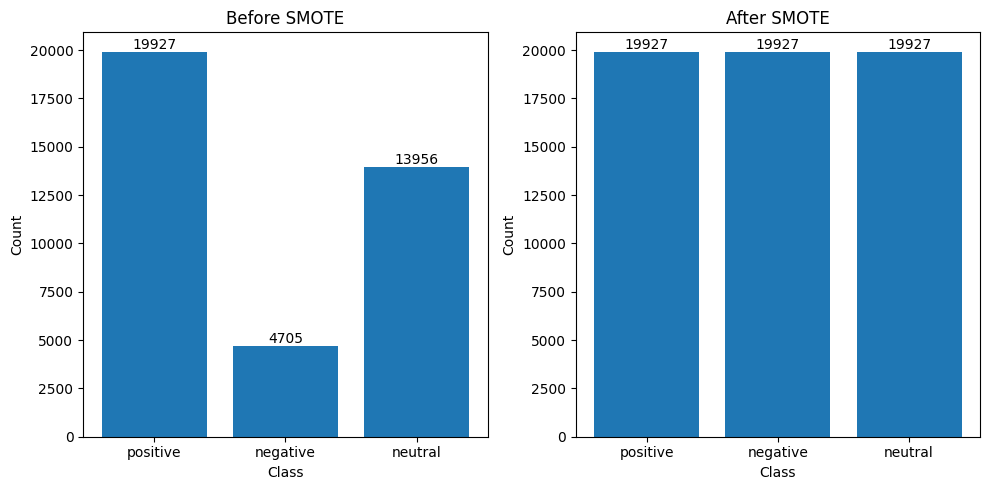

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


# Misal X_train_features dan y_train adalah data Anda sebelum SMOTE

# Membuat plot sebelum SMOTE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
counts_before = Counter(y_train)
plt.bar(counts_before.keys(), counts_before.values())
plt.title('Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
for i, count in enumerate(counts_before.values()):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Membuat plot sesudah SMOTE
plt.subplot(1, 2, 2)
counts_after = Counter(y_train_balanced)
plt.bar(counts_after.keys(), counts_after.values())
plt.title('After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
for i, count in enumerate(counts_after.values()):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Naive Bayes Model

In [62]:
from sklearn.naive_bayes import MultinomialNB

model_naive_bayes = MultinomialNB()
model_naive_bayes.fit(X_train_balanced, y_train_balanced)

MultinomialNB()

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = model_naive_bayes.predict(X_test_features)

accuracy_naive_bayes = accuracy_score(y_test, y_pred)
precision_naive_bayes = precision_score(y_test, y_pred, average="weighted")
recall_naive_bayes = recall_score(y_test, y_pred, average="weighted")
f1_naive_bayes = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy_naive_bayes:.4f}")
print(f"Precision: {precision_naive_bayes:.4f}")
print(f"Recall: {recall_naive_bayes:.4f}")
print(f"F1-score: {f1_naive_bayes:.4f}")

Accuracy: 0.8105
Precision: 0.8580
Recall: 0.8105
F1-score: 0.8233


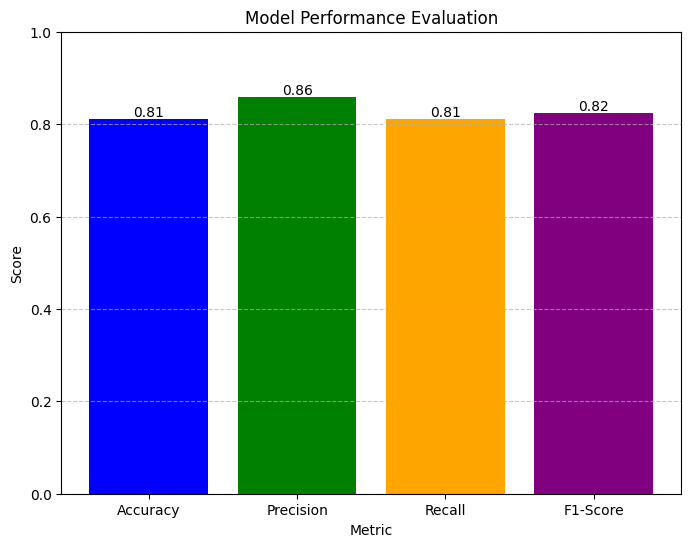

In [18]:
import matplotlib.pyplot as plt

# Sample metric names and corresponding values
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [accuracy_naive_bayes, precision_naive_bayes, recall_naive_bayes, f1_naive_bayes]

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['b', 'g', 'orange', 'purple'])
plt.xlabel("Metric")
plt.ylabel("Score")
plt.title("Model Performance Evaluation")
plt.ylim(0, 1)  # Set y-axis limit to range from 0 to 1 for all metrics
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             round(value, 2),
             ha='center',
             va='bottom')

plt.show()


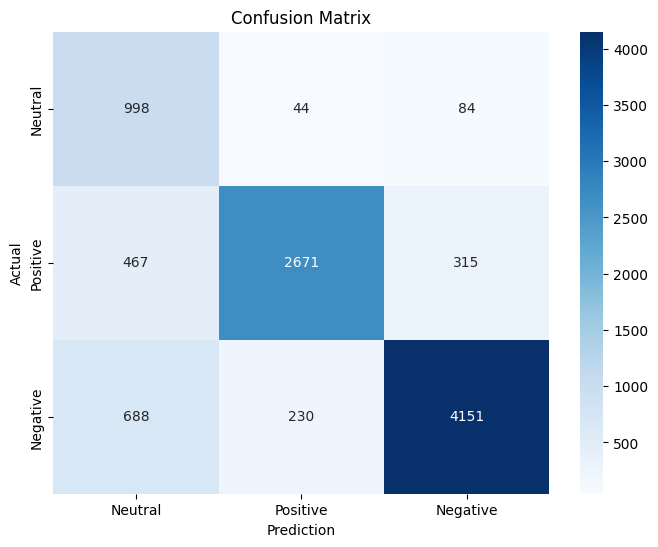

In [19]:
# Menghitung confusion matrix
conf_matrix_naive_bayes = confusion_matrix(y_test, y_pred)

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_naive_bayes, annot=True, fmt="d", cmap="Blues", xticklabels=['Neutral', 'Positive', 'Negative'], yticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

# Support Vector Machine Model

In [20]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

model_svm = SVC(kernel='linear', C=1E10)
model_svm.fit(X_train_balanced, y_train_balanced)

SVC(C=10000000000.0, kernel='linear')

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = model_svm.predict(X_test_features)

accuracy_svm = accuracy_score(y_test, y_pred)
precision_svm = precision_score(y_test, y_pred, average="weighted")
recall_svm = recall_score(y_test, y_pred, average="weighted")
f1_svm = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")

Accuracy: 0.9538
Precision: 0.9539
Recall: 0.9538
F1-score: 0.9537


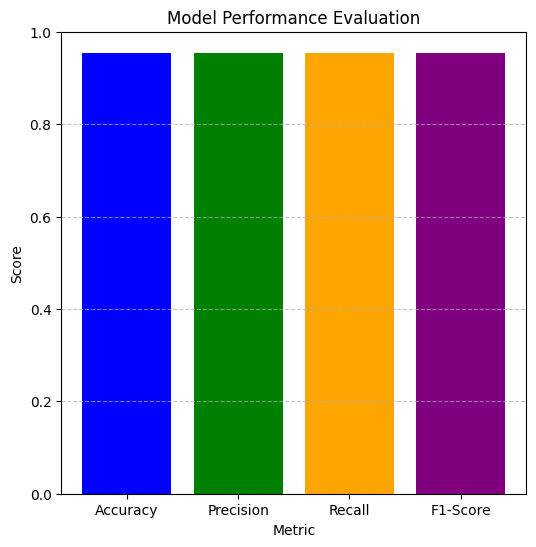

In [22]:
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [accuracy_svm, precision_svm, recall_svm, f1_svm]

plt.figure(figsize=(6, 6))
plt.bar(metrics, values, color=['b', 'g', 'orange', 'purple'])
plt.xlabel("Metric")
plt.ylabel("Score")
plt.title("Model Performance Evaluation")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

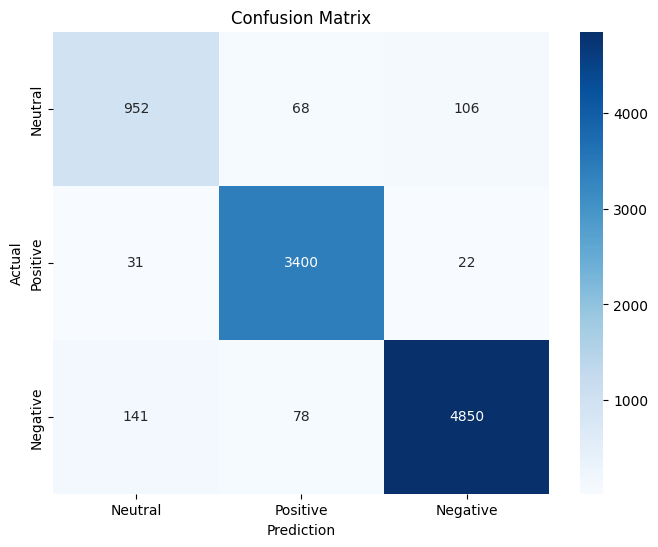

In [23]:
# Menghitung confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred)

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=['Neutral', 'Positive', 'Negative'], yticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

# Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
# Train the model
model_linear_regression = LogisticRegression()
model_linear_regression.fit(X_train_balanced, y_train_balanced)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict sentiment on test data
y_pred = model_linear_regression.predict(X_test_features)

# Evaluate model performance using accuracy, precision, recall, and F1-score
accuracy_linear_regression = accuracy_score(y_test, y_pred)
precision_linear_regression = precision_score(y_test, y_pred, average="weighted")
recall_linear_regression = recall_score(y_test, y_pred, average="weighted")
f1_linear_regression = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy_linear_regression:.4f}")
print(f"Precision: {precision_linear_regression:.4f}")
print(f"Recall: {recall_linear_regression:.4f}")
print(f"F1-score: {f1_linear_regression:.4f}")

Accuracy: 0.9385
Precision: 0.9403
Recall: 0.9385
F1-score: 0.9387


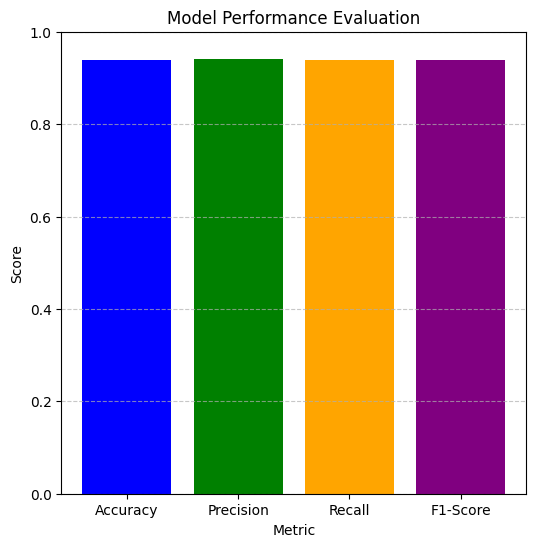

In [26]:
# Define metric names and corresponding values
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
values = [accuracy_linear_regression, precision_linear_regression, recall_linear_regression, f1_linear_regression]

# Create the bar chart
plt.figure(figsize=(6, 6))
plt.bar(metrics, values, color=['b', 'g', 'orange', 'purple'])
plt.xlabel("Metric")
plt.ylabel("Score")
plt.title("Model Performance Evaluation")
plt.ylim(0, 1)  # Set y-axis limit to range from 0 to 1 for all metrics
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

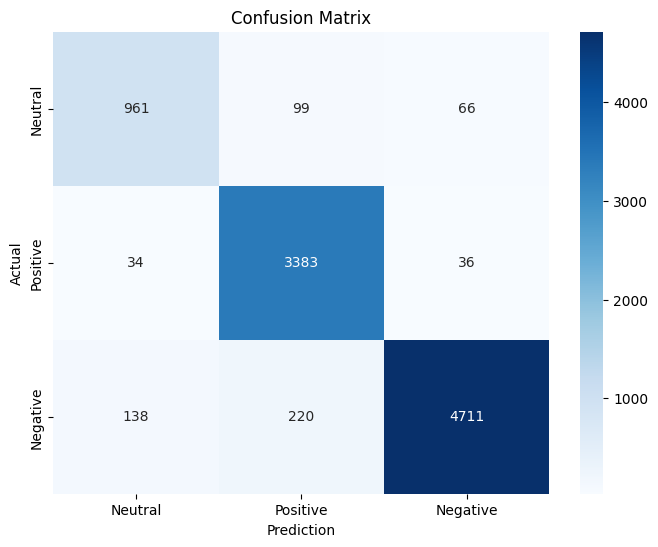

In [27]:
# Menghitung confusion matrix
conf_matrix_linear_regression = confusion_matrix(y_test, y_pred)

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_linear_regression, annot=True, fmt="d", cmap="Blues", xticklabels=['Neutral', 'Positive', 'Negative'], yticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

# Evaluation

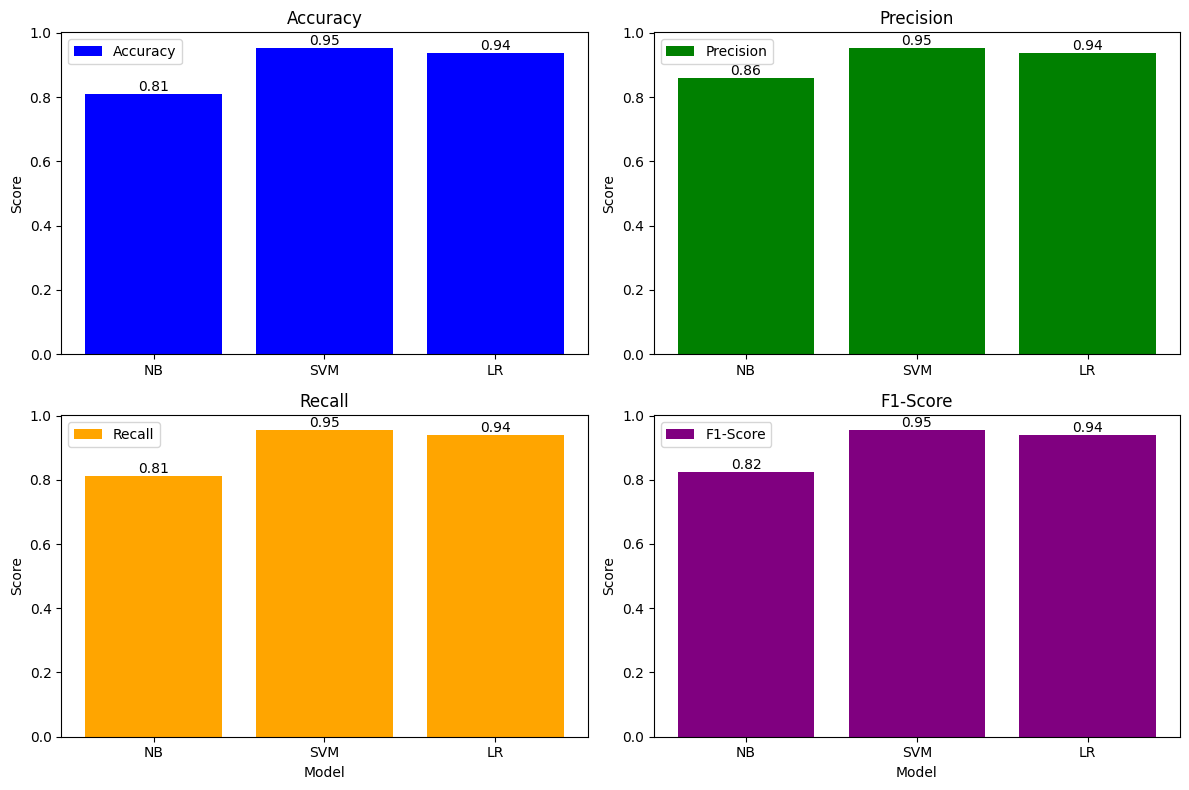

In [28]:
import matplotlib.pyplot as plt

# Define model names and metric values
model_names = ["NB", "SVM", "LR"]
accuracy_values = [accuracy_naive_bayes, accuracy_svm,accuracy_linear_regression]
precision_values = [precision_naive_bayes, precision_svm,accuracy_linear_regression]
recall_values = [recall_naive_bayes, recall_svm,accuracy_linear_regression]
f1_values = [f1_naive_bayes, f1_svm,accuracy_linear_regression]

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot accuracy
bars = axes[0, 0].bar(model_names, accuracy_values, color='b', label='Accuracy')
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_ylabel('Score')
axes[0, 0].legend()
for bar, val in zip(bars, accuracy_values):
    axes[0, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(val, 2), ha='center', va='bottom')

# Plot precision
bars = axes[0, 1].bar(model_names, precision_values, color='g', label='Precision')
axes[0, 1].set_title('Precision')
axes[0, 1].set_ylabel('Score')
axes[0, 1].legend()
for bar, val in zip(bars, precision_values):
    axes[0, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(val, 2), ha='center', va='bottom')

# Plot recall
bars = axes[1, 0].bar(model_names, recall_values, color='orange', label='Recall')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('Score')
axes[1, 0].legend()
for bar, val in zip(bars, recall_values):
    axes[1, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(val, 2), ha='center', va='bottom')

# Plot F1-score
bars = axes[1, 1].bar(model_names, f1_values, color='purple', label='F1-Score')
axes[1, 1].set_title('F1-Score')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
for bar, val in zip(bars, f1_values):
    axes[1, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(val, 2), ha='center', va='bottom')

# Adjust layout and display chart
fig.tight_layout()
plt.show()

# **Create Model**

# **Death Cross 29 Mei 2023**

In [75]:
path ='/content/drive/MyDrive/Colab Notebooks/Dataset Penelitian/29 Mei 2023 Death Cross/29 Mei 2023.xlsx'
data = pd.read_excel(path)
data

url                   name  \
0            https://twitter.com/Bitcoin                Bitcoin   
1               https://twitter.com/lopp           Jameson Lopp   
2     https://twitter.com/marshallmixing       Brandon Marshall   
3    https://twitter.com/uniqloindonesia        uniqloindonesia   
4       https://twitter.com/0xMayaMaster             ɱɑყɑɱɑεʂƚɾ   
..                                   ...                    ...   
227  https://twitter.com/MrRogerLStewar2  Mr Roger L Stewart Sr   
228        https://twitter.com/sirji_eth              sirji.eth   
229  https://twitter.com/tarunpa45853215           tarun pandey   
230       https://twitter.com/SasHuseyin            Hüseyin ŞAŞ   
231          https://twitter.com/Bitcoin                Bitcoin   

             username                     date  \
0            @Bitcoin  Click to Follow Bitcoin   
1               @lopp             May 31, 2023   
2     @marshallmixing             May 31, 2023   
3    @uniqloindonesia          From uniqlo.com   
4       @0xMayaMaster              Jun 2, 2023   
..                ...                      ...   
227  @MrRogerLStewar2             May 26, 2023   
228        @sirji_eth             May 26, 2023   
229  @tarunpa45853215             May 26, 2023   
230       @SasHuseyin             Jul 19, 2023   
231          @Bitcoin                       2h   

                                                  text  \
0                                             We found   
1                                   Don't dox me, bro!   
2                 People who have driven on 280 before   
3                                       #UNIQLORamadan   
4                                               When ?   
..                                                 ...   
227  So for those who wants to see how what an audi...   
228                             Anyone for this Domain   
229                              is available for sale   
230  1Bx9tm42JG7qBuTQ6xGiezrC62hc98QeQG bitcoin adress   
231  uptrend signals a bullish future for the digit...   

                                          Cleaned_Text  \
0                                             we found   
1                                     don t dox me bro   
2                    people who have driven on  before   
3                                        uniqloramadan   
4                                                 when   
..                                                 ...   
227  so for those who wants to see how what an audi...   
228                             anyone for this domain   
229                              is available for sale   
230            bxtmjgqbutqxgiezrchcqeqg bitcoin adress   
231  uptrend signals a bullish future for the digit...   

                                          Tokenization  \
0                                      ['we', 'found']   
1                     ['don', 't', 'dox', 'me', 'bro']   
2    ['people', 'who', 'have', 'driven', 'on', 'bef...   
3                                    ['uniqloramadan']   
4                                             ['when']   
..                                                 ...   
227  ['so', 'for', 'those', 'who', 'wants', 'to', '...   
228                ['anyone', 'for', 'this', 'domain']   
229                 ['is', 'available', 'for', 'sale']   
230  ['bxtmjgqbutqxgiezrchcqeqg', 'bitcoin', 'adress']   
231  ['uptrend', 'signals', 'a', 'bullish', 'future...   

                                             Stopwords  \
0                                            ['found']   
1                                       ['dox', 'bro']   
2                                 ['people', 'driven']   
3                                    ['uniqloramadan']   
4                                                   []   
..                                                 ...   
227  ['wants', 'see', 'audit', 'look', 'like', 'peo...   
228                               ['anyone', 'domain']   
229               

**Sentiment Naive Bayes**

In [76]:
data['End_Text'].fillna('', inplace=True)
new_text_vec = vectorizer.transform(data['End_Text'])
data['Sentiment_NB_29_05_2023'] = model_naive_bayes.predict(new_text_vec)

In [81]:
sentiment_counts = data['Sentiment_NB_29_05_2023'].value_counts()
total_samples = len(data)

sentiment_percentages = (sentiment_counts / total_samples) * 100

print("Persentase setiap sentimen:")
print(sentiment_percentages)


Persentase setiap sentimen:
Sentiment_NB_29_05_2023
negative    45.689655
positive    40.086207
neutral     14.224138
Name: count, dtype: float64


**Sentimen Support Vector Machine**

In [77]:
data['Sentiment_SVM_29_05_2023'] = model_svm.predict(new_text_vec)

In [84]:
sentiment_counts = data['Sentiment_SVM_29_05_2023'].value_counts()
total_samples = len(data)

sentiment_percentages = (sentiment_counts / total_samples) * 100

print("Persentase setiap sentimen:")
print(sentiment_percentages)


Persentase setiap sentimen:
Sentiment_SVM_29_05_2023
neutral     50.431034
positive    35.775862
negative    13.793103
Name: count, dtype: float64


**Sentiment Linear Regression**

In [78]:
data['Sentiment_LR_29_05_2023'] = model_linear_regression.predict(new_text_vec)

In [85]:
sentiment_counts = data['Sentiment_LR_29_05_2023'].value_counts()
total_samples = len(data)

sentiment_percentages = (sentiment_counts / total_samples) * 100

print("Persentase setiap sentimen:")
print(sentiment_percentages)


Persentase setiap sentimen:
Sentiment_LR_29_05_2023
positive    41.379310
neutral     40.948276
negative    17.672414
Name: count, dtype: float64


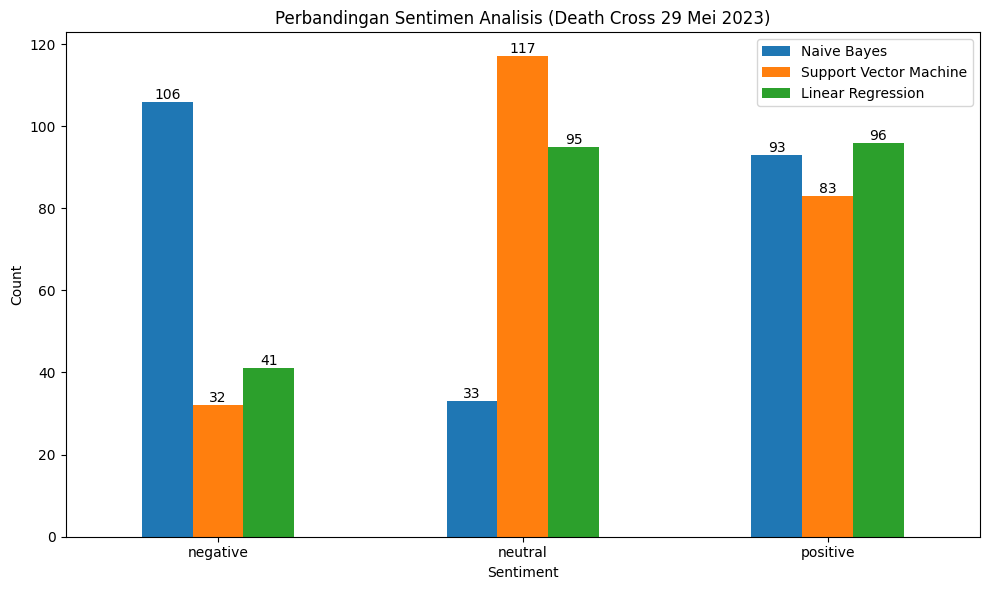

In [80]:
import matplotlib.pyplot as plt

sentiment_NB = data['Sentiment_NB_29_05_2023'].value_counts()
sentiment_SVM = data['Sentiment_SVM_29_05_2023'].value_counts()
sentiment_LR = data['Sentiment_LR_29_05_2023'].value_counts()

sentiment_combined = pd.DataFrame({
    'Naive Bayes': sentiment_NB,
    'Support Vector Machine': sentiment_SVM,
    'Linear Regression': sentiment_LR
})

ax = sentiment_combined.plot(kind='bar', figsize=(10, 6))
plt.title('Perbandingan Sentimen Analisis (Death Cross 29 Mei 2023)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()


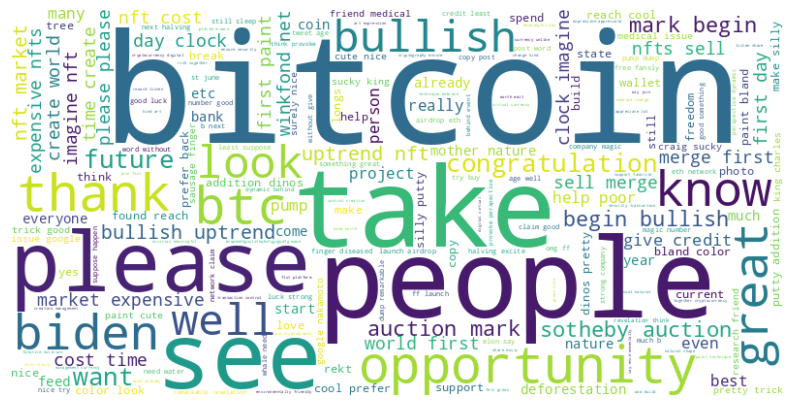

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan teks dari ketiga kolom
positive_text = ' '.join(data[data['Sentiment_NB_29_05_2023'] == 'positive']['End_Text']) + ' '
positive_text += ' '.join(data[data['Sentiment_SVM_29_05_2023'] == 'positive']['End_Text']) + ' '
positive_text += ' '.join(data[data['Sentiment_LR_29_05_2023'] == 'positive']['End_Text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

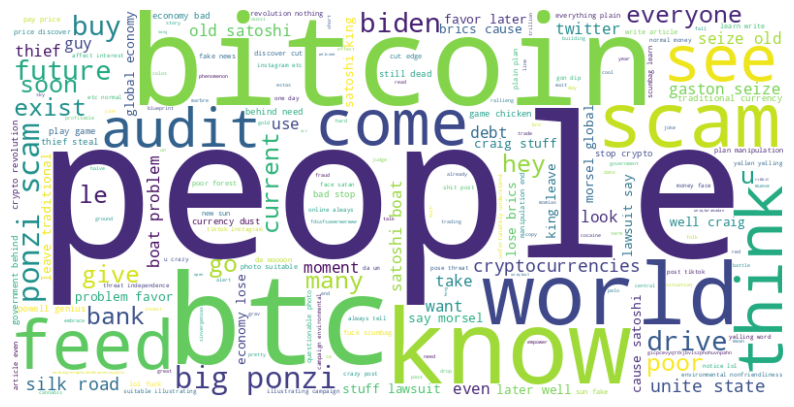

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan teks dari ketiga kolom
negative_text = ' '.join(data[data['Sentiment_NB_29_05_2023'] == 'negative']['End_Text']) + ' '
negative_text += ' '.join(data[data['Sentiment_SVM_29_05_2023'] == 'negative']['End_Text']) + ' '
negative_text += ' '.join(data[data['Sentiment_LR_29_05_2023'] == 'negative']['End_Text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

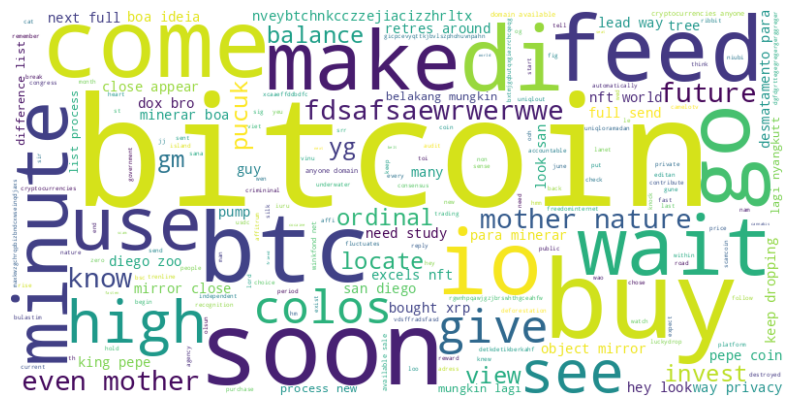

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan teks dari ketiga kolom
neutral_text = ' '.join(data[data['Sentiment_NB_29_05_2023'] == 'neutral']['End_Text']) + ' '
neutral_text += ' '.join(data[data['Sentiment_SVM_29_05_2023'] == 'neutral']['End_Text']) + ' '
neutral_text += ' '.join(data[data['Sentiment_LR_29_05_2023'] == 'neutral']['End_Text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# **Golden Cross 19 Juni 2023**

In [86]:
path ='/content/drive/MyDrive/Colab Notebooks/Dataset Penelitian/19 Juni 2023 Golden Cross/19 Juni 2023.xlsx'
data = pd.read_excel(path)
data

url                    name  \
0            https://twitter.com/Bitcoin                 Bitcoin   
1        https://twitter.com/andrew_igna             Andrew Igna   
2    https://twitter.com/uniqloindonesia         uniqloindonesia   
3         https://twitter.com/FishFishFF  FishFishFF.eth | AlexC   
4          https://twitter.com/Mongi2025              Tiga Mongi   
..                                   ...                     ...   
736        https://twitter.com/MrsCashOG               MrsCashOG   
737        https://twitter.com/hkn067868            Hakan Söyler   
738            https://twitter.com/U4Nb4                     XXX   
739        https://twitter.com/bradmleeb           BRAD | LEEBER   
740     https://twitter.com/freePalstein        Kuwait UAE Qatar   

             username                                               text  \
0            @Bitcoin                                              Views   
1        @andrew_igna                                 Does anybody care?   
2    @uniqloindonesia                                    and all stores!   
3         @FishFishFF                       I dun think so. $23,294 !!!!   
4          @Mongi2025                  Time to celebrate the new heights   
..                ...                                                ...   
736        @MrsCashOG     https://abs-0.twimg.com/emoji/v2/svg/1f4af.svg   
737        @hkn067868  https://abs.twimg.com/hashflags/BF-10240_Binan...   
738            @U4Nb4     https://abs-0.twimg.com/emoji/v2/svg/1fae3.svg   
739        @bradmleeb  https://abs-0.twimg.com/emoji/v2/svg/1f44a-1f3...   
740     @freePalstein  https://abs-0.twimg.com/emoji/v2/svg/1f1f5-1f1...   

                                           date  \
0                                           NaN   
1                                  Jun 18, 2023   
2                               From uniqlo.com   
3                                  Jun 18, 2023   
4                                  Jun 20, 2023   
..                                          ...   
736                                         NaN   
737            Retweet if you want 2.3 Trillion   
738  bc1qm4hfsqh2n6qpth6jxtqctt0g9dgv73jn6ll7aj   
739                                         NaN   
740                               Free palstein   

                                          Cleaned_Text  \
0                                                views   
1                                    does anybody care   
2                                       and all stores   
3                                       i dun think so   
4                    time to celebrate the new heights   
..                                                 ...   
736                      twimg com emoji v svg faf svg   
737  binanceqcampaignemoji bf binanceqcampaignemoji...   
738                      twimg com emoji v svg fae svg   
739                   twimg com emoji v svg fa ffd svg   
740                    twimg com emoji v svg ff ff svg   

                                          Tokenization  \
0                                            ['views']   
1                          ['does', 'anybody', 'care']   
2                             ['and', 'all', 'stores']   
3                          ['i', 'dun', 'think', 'so']   
4    ['time', 'to', 'celebrate', 'the', 'new', 'hei...   
..                                                 ...   
736  ['twimg', 'com', 'emoji', 'v', 'svg', 'faf', '...   
737  ['binanceqcampaignemoji', 'bf', 'binanceqcampa...   
738  ['twimg', 'com', 'emoji', 'v', 'svg', 'fae', '...   
739  ['twimg', 'com', 'emoji', 'v', 'svg', 'fa', 'f...   
740  ['twimg', 'com', 'emoji', 'v', 'svg', 'ff', 'f...   

                                             Stopwords  \
0                                            ['views']   
1                                  ['anybody', 'care']   
2                                           ['stores']   
3                                     ['dun', 'think']   
4         

**Sentiment Naive Bayes**

In [87]:
data['End_Text'].fillna('', inplace=True)
new_text_vec = vectorizer.transform(data['End_Text'])
data['Sentiment_NB_19_06_2023'] = model_naive_bayes.predict(new_text_vec)

In [93]:
sentiment_counts = data['Sentiment_NB_19_06_2023'].value_counts()
total_samples = len(data)

print ("Data setiap sentimen")
print (sentiment_counts)

sentiment_percentages = (sentiment_counts / total_samples) * 100

print("Persentase setiap sentimen:")
print(sentiment_percentages)

Data setiap sentimen
Sentiment_NB_19_06_2023
positive    311
negative    285
neutral     145
Name: count, dtype: int64
Persentase setiap sentimen:
Sentiment_NB_19_06_2023
positive    41.970310
negative    38.461538
neutral     19.568151
Name: count, dtype: float64


**Sentiment Support Vector Machine**

In [88]:
data['Sentiment_SVM_19_06_2023'] = model_svm.predict(new_text_vec)

In [94]:
sentiment_counts = data['Sentiment_SVM_19_06_2023'].value_counts()
total_samples = len(data)

print ("Data setiap sentimen")
print (sentiment_counts)

sentiment_percentages = (sentiment_counts / total_samples) * 100

print("Persentase setiap sentimen:")
print(sentiment_percentages)

Data setiap sentimen
Sentiment_SVM_19_06_2023
neutral     384
positive    283
negative     74
Name: count, dtype: int64
Persentase setiap sentimen:
Sentiment_SVM_19_06_2023
neutral     51.821862
positive    38.191633
negative     9.986505
Name: count, dtype: float64


**Sentiment Linear Regression**

In [89]:
data['Sentiment_LR_19_06_2023'] = model_linear_regression.predict(new_text_vec)

In [95]:
sentiment_counts = data['Sentiment_LR_19_06_2023'].value_counts()
total_samples = len(data)

print ("Data setiap sentimen")
print (sentiment_counts)

sentiment_percentages = (sentiment_counts / total_samples) * 100

print("Persentase setiap sentimen:")
print(sentiment_percentages)

Data setiap sentimen
Sentiment_LR_19_06_2023
neutral     331
positive    327
negative     83
Name: count, dtype: int64
Persentase setiap sentimen:
Sentiment_LR_19_06_2023
neutral     44.669366
positive    44.129555
negative    11.201080
Name: count, dtype: float64


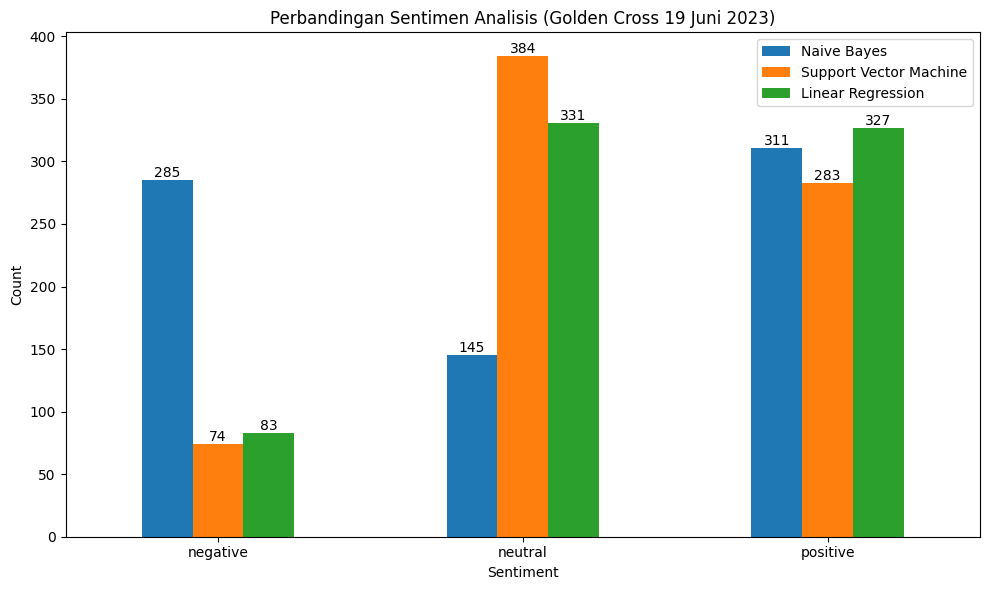

In [96]:
import matplotlib.pyplot as plt

sentiment_NB = data['Sentiment_NB_19_06_2023'].value_counts()
sentiment_SVM = data['Sentiment_SVM_19_06_2023'].value_counts()
sentiment_LR = data['Sentiment_LR_19_06_2023'].value_counts()

sentiment_combined = pd.DataFrame({
    'Naive Bayes': sentiment_NB,
    'Support Vector Machine': sentiment_SVM,
    'Linear Regression': sentiment_LR
})

ax = sentiment_combined.plot(kind='bar', figsize=(10, 6))
plt.title('Perbandingan Sentimen Analisis (Golden Cross 19 Juni 2023)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()


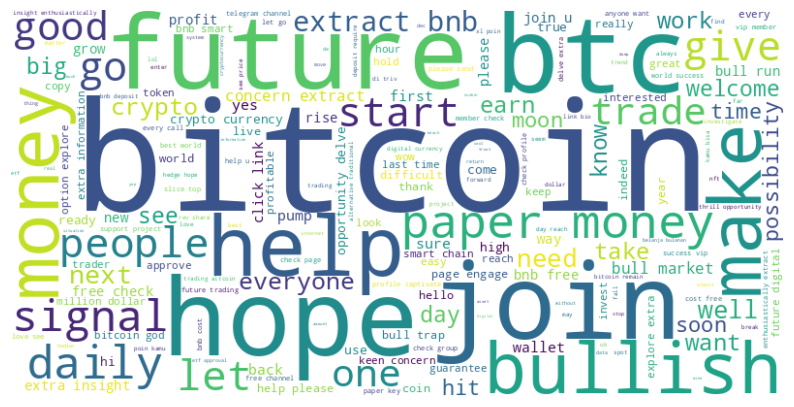

In [98]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan teks dari ketiga kolom
positive_text = ' '.join(data[data['Sentiment_NB_19_06_2023'] == 'positive']['End_Text']) + ' '
positive_text += ' '.join(data[data['Sentiment_SVM_19_06_2023'] == 'positive']['End_Text']) + ' '
positive_text += ' '.join(data[data['Sentiment_LR_19_06_2023'] == 'positive']['End_Text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

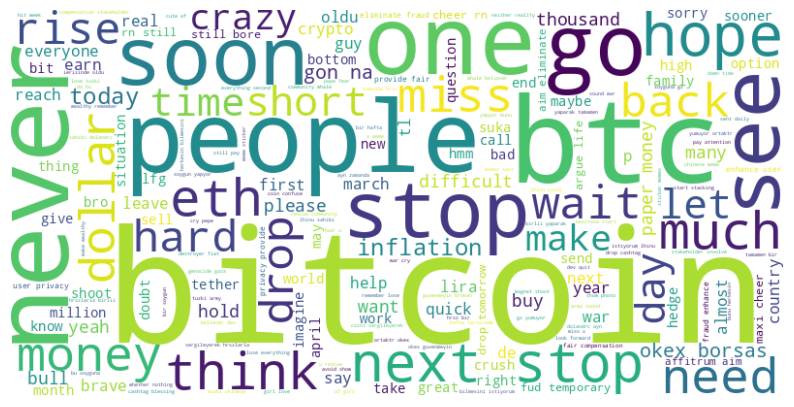

In [99]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan teks dari ketiga kolom
negative_text = ' '.join(data[data['Sentiment_NB_19_06_2023'] == 'negative']['End_Text']) + ' '
negative_text += ' '.join(data[data['Sentiment_SVM_19_06_2023'] == 'negative']['End_Text']) + ' '
negative_text += ' '.join(data[data['Sentiment_LR_19_06_2023'] == 'negative']['End_Text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

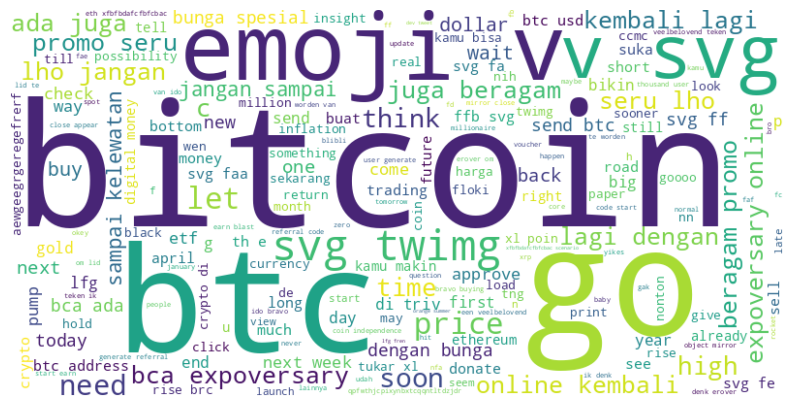

In [100]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan teks dari ketiga kolom
neutral_text = ' '.join(data[data['Sentiment_NB_19_06_2023'] == 'neutral']['End_Text']) + ' '
neutral_text += ' '.join(data[data['Sentiment_SVM_19_06_2023'] == 'neutral']['End_Text']) + ' '
neutral_text += ' '.join(data[data['Sentiment_LR_19_06_2023'] == 'neutral']['End_Text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# **Death Cross 31 Juli 2023**

In [101]:
path ='/content/drive/MyDrive/Colab Notebooks/Dataset Penelitian/31 Juli 2023 Death Cross/31 Juli 2023.xlsx'
data = pd.read_excel(path)
data

url                name  \
0            https://twitter.com/Bitcoin             Bitcoin   
1    https://twitter.com/herbohipponinja     HerboHippoNinja   
2     https://twitter.com/EwannnaLoopSha  Ewanna Loopsha 256   
3             https://twitter.com/f00dl3              f00dl3   
4           https://twitter.com/krakenfx     Kraken Exchange   
..                                   ...                 ...   
385          https://twitter.com/Clint_9               Clint   
386    https://twitter.com/MyNameisErikk                Eric   
387         https://twitter.com/ShopeeID    Shopee Indonesia   
388  https://twitter.com/SunlandNew12116         Crypto King   
389  https://twitter.com/MeganDa23705967         Megan Davis   

             username                                               text  \
0            @Bitcoin                                                399   
1    @herbohipponinja                                         Quick mafs   
2     @EwannnaLoopSha  (∂ + m) ψ = 0 is perhaps Dirac's most famous e...   
3             @f00dl3                   So that means it's going to 12k?   
4           @krakenfx                                               7.1K   
..                ...                                                ...   
385          @Clint_9  . \nNo gas fees etc, just hold in wallet. \n\n...   
386    @MyNameisErikk                              Everything is showing   
387         @ShopeeID  Photostrip Akrilik nih fixxx bikin meja kamu m...   
388  @SunlandNew12116  In my opinion, providing Secret Service protec...   
389  @MeganDa23705967  Cryptocurrencies are a powerful tool for diver...   

                  date                                       Cleaned_Text  \
0                  NaN                                                NaN   
1          Aug 2, 2023                                         quick mafs   
2          Aug 3, 2023  m   is perhaps dirac s most famous equation an...   
3          Aug 2, 2023                      so that means it s going to k   
4          Aug 2, 2023                                                  k   
..                 ...                                                ...   
385       Jul 28, 2023  no gas fees etc just hold in wallet live in us...   
386       Jul 28, 2023                              everything is showing   
387  From shopee.co.id  photostrip akrilik nih fixxx bikin meja kamu m...   
388       Jul 31, 2023  in my opinion providing secret service protect...   
389        Aug 2, 2023  cryptocurrencies are a powerful tool for diver...   

                                          Tokenization  \
0                                                   []   
1                                    ['quick', 'mafs']   
2    ['m', 'is', 'perhaps', 'dirac', 's', 'most', '...   
3    ['so', 'that', 'means', 'it', 's', 'going', 't...   
4                                                ['k']   
..                                                 ...   
385  ['no', 'gas', 'fees', 'etc', 'just', 'hold', '...   
386                    ['everything', 'is', 'showing']   
387  ['photostrip', 'akrilik', 'nih', 'fixxx', 'bik...   
388  ['in', 'my', 'opinion', 'providing', 'secret',...   
389  ['cryptocurrencies', 'are', 'a', 'powerful', '...   

                                             Stopwords  \
0                                                   []   
1                                    ['quick', 'mafs']   
2    ['perhaps', 'dirac', 'famous', 'equation', 'me...   
3                              ['means', 'going', 'k']   
4                                                ['k']   
..                                                 ...   
385  ['gas', 'fees', 'etc', 'hold', 'wallet', 'live...   
386                          ['everything', 'showing']   
387  ['photostrip', 'akrilik', 'nih', 'fixxx', 'bik...   
388  ['opinion', 'providing', 'secret', 'service', ...   
389  ['cryptocurrencies', 'powerful', 'tool', 'dive...   

                                    

**Sentiment Naive Bayes**

In [102]:
data['End_Text'].fillna('', inplace=True)
new_text_vec = vectorizer.transform(data['End_Text'])
data['Sentiment_NB_31_07_2023'] = model_naive_bayes.predict(new_text_vec)

In [106]:
sentiment_counts = data['Sentiment_NB_31_07_2023'].value_counts()
total_samples = len(data)

print ("Data setiap sentimen")
print (sentiment_counts)

sentiment_percentages = (sentiment_counts / total_samples) * 100

print("Persentase setiap sentimen:")
print(sentiment_percentages)

Data setiap sentimen
Sentiment_NB_31_08_2023
positive    166
negative    154
neutral      70
Name: count, dtype: int64
Persentase setiap sentimen:
Sentiment_NB_31_08_2023
positive    42.564103
negative    39.487179
neutral     17.948718
Name: count, dtype: float64


**Sentiment Support Vector Machine**

In [103]:
data['Sentiment_SVM_31_07_2023'] = model_svm.predict(new_text_vec)

In [107]:
sentiment_counts = data['Sentiment_SVM_31_07_2023'].value_counts()
total_samples = len(data)

print ("Data setiap sentimen")
print (sentiment_counts)

sentiment_percentages = (sentiment_counts / total_samples) * 100

print("Persentase setiap sentimen:")
print(sentiment_percentages)

Data setiap sentimen
Sentiment_SVM_31_08_2023
neutral     190
positive    147
negative     53
Name: count, dtype: int64
Persentase setiap sentimen:
Sentiment_SVM_31_08_2023
neutral     48.717949
positive    37.692308
negative    13.589744
Name: count, dtype: float64


**Sentiment Linear Regression**

In [104]:
data['Sentiment_LR_31_07_2023'] = model_linear_regression.predict(new_text_vec)

In [108]:
sentiment_counts = data['Sentiment_LR_31_07_2023'].value_counts()
total_samples = len(data)

print ("Data setiap sentimen")
print (sentiment_counts)

sentiment_percentages = (sentiment_counts / total_samples) * 100

print("Persentase setiap sentimen:")
print(sentiment_percentages)

Data setiap sentimen
Sentiment_LR_31_08_2023
neutral     173
positive    168
negative     49
Name: count, dtype: int64
Persentase setiap sentimen:
Sentiment_LR_31_08_2023
neutral     44.358974
positive    43.076923
negative    12.564103
Name: count, dtype: float64


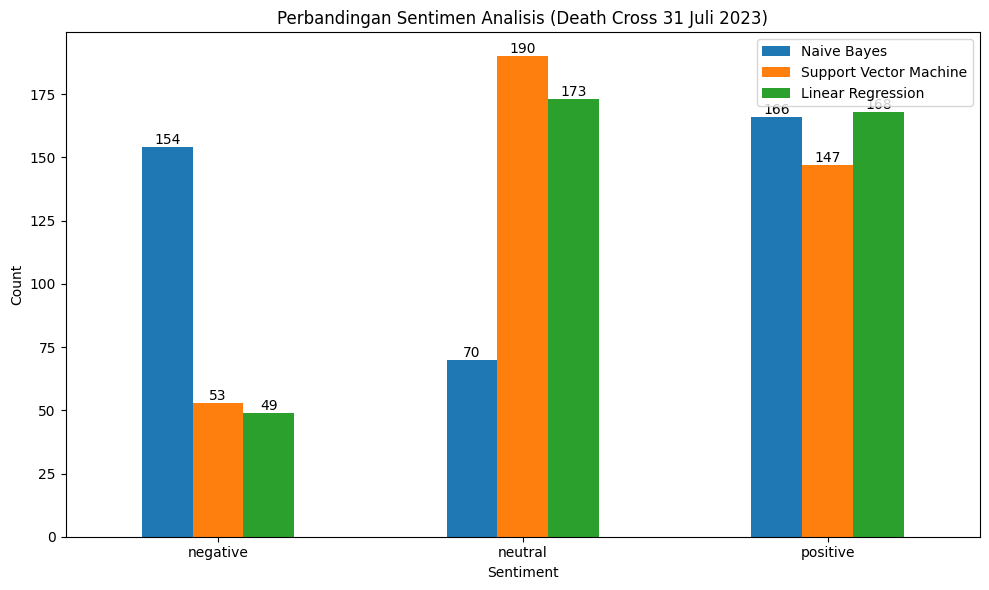

In [109]:
import matplotlib.pyplot as plt

sentiment_NB = data['Sentiment_NB_31_07_2023'].value_counts()
sentiment_SVM = data['Sentiment_SVM_31_07_2023'].value_counts()
sentiment_LR = data['Sentiment_LR_31_07_2023'].value_counts()

sentiment_combined = pd.DataFrame({
    'Naive Bayes': sentiment_NB,
    'Support Vector Machine': sentiment_SVM,
    'Linear Regression': sentiment_LR
})

ax = sentiment_combined.plot(kind='bar', figsize=(10, 6))
plt.title('Perbandingan Sentimen Analisis (Death Cross 31 Juli 2023)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()


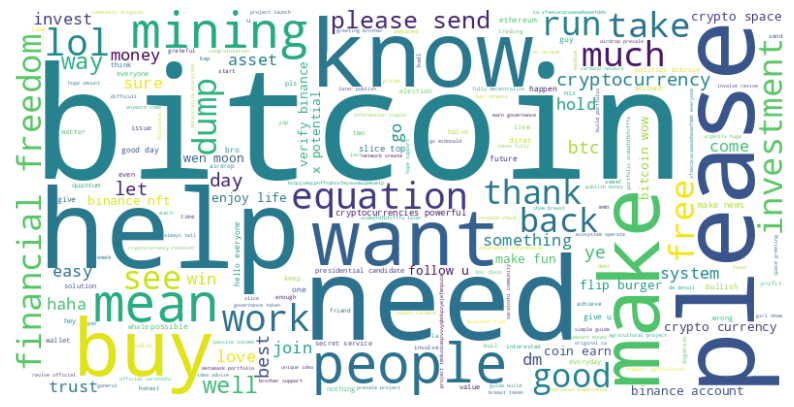

In [110]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan teks dari ketiga kolom
positive_text = ' '.join(data[data['Sentiment_NB_31_08_2023'] == 'positive']['End_Text']) + ' '
positive_text += ' '.join(data[data['Sentiment_SVM_31_08_2023'] == 'positive']['End_Text']) + ' '
positive_text += ' '.join(data[data['Sentiment_LR_31_08_2023'] == 'positive']['End_Text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

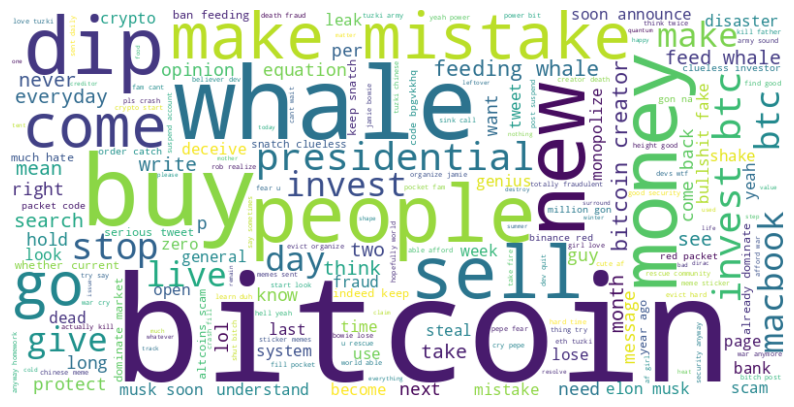

In [111]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan teks dari ketiga kolom
negative_text = ' '.join(data[data['Sentiment_NB_31_08_2023'] == 'negative']['End_Text']) + ' '
negative_text += ' '.join(data[data['Sentiment_SVM_31_08_2023'] == 'negative']['End_Text']) + ' '
negative_text += ' '.join(data[data['Sentiment_LR_31_08_2023'] == 'negative']['End_Text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

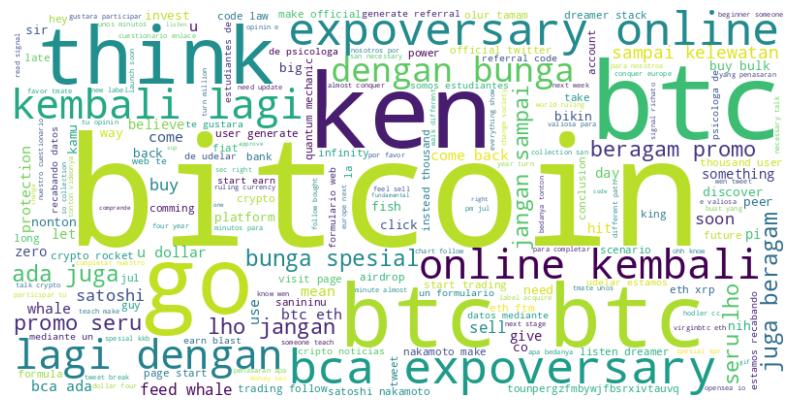

In [112]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan teks dari ketiga kolom
neutral_text = ' '.join(data[data['Sentiment_NB_31_08_2023'] == 'neutral']['End_Text']) + ' '
neutral_text += ' '.join(data[data['Sentiment_SVM_31_08_2023'] == 'neutral']['End_Text']) + ' '
neutral_text += ' '.join(data[data['Sentiment_LR_31_08_2023'] == 'neutral']['End_Text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# **Golden Cross 16 Oktober 2023**

In [113]:
path ='/content/drive/MyDrive/Colab Notebooks/Dataset Penelitian/16 Oktober 2023 Golden Cross/16 Oktober 2023.xlsx'
data = pd.read_excel(path)
data

url                 name  \
0             https://twitter.com/Bitcoin              Bitcoin   
1     https://twitter.com/hdhfkdnfnfnkdix                  Gob   
2          https://twitter.com/SantoshYKT  Santosh kumar Yadav   
3      https://twitter.com/MantaisMoney15       Nathan Resnick   
4          https://twitter.com/SantoshYKT  Santosh kumar Yadav   
...                                   ...                  ...   
1196        https://twitter.com/MrsCashOG            MrsCashOG   
1197        https://twitter.com/hkn067868         Hakan Söyler   
1198            https://twitter.com/U4Nb4                  XXX   
1199        https://twitter.com/bradmleeb        BRAD | LEEBER   
1200     https://twitter.com/freePalstein     Kuwait UAE Qatar   

              username                                               text  \
0             @Bitcoin                                 13.9040 oz#Bitcoin   
1     @hdhfkdnfnfnkdix                                       Bitcoin$Gold   
2          @SantoshYKT                                         ,good news   
3      @MantaisMoney15  Just received my $12536 back from gas spent.Ch...   
4          @SantoshYKT                                   Thanx for update   
...                ...                                                ...   
1196        @MrsCashOG     https://abs-0.twimg.com/emoji/v2/svg/1f4af.svg   
1197        @hkn067868  https://abs.twimg.com/hashflags/BF-10240_Binan...   
1198            @U4Nb4     https://abs-0.twimg.com/emoji/v2/svg/1fae3.svg   
1199        @bradmleeb  https://abs-0.twimg.com/emoji/v2/svg/1f44a-1f3...   
1200     @freePalstein  https://abs-0.twimg.com/emoji/v2/svg/1f1f5-1f1...   

                                            date  \
0                                            NaN   
1                                   Oct 15, 2023   
2                                   Oct 15, 2023   
3                              From ethereum.org   
4                                   Oct 15, 2023   
...                                          ...   
1196                                         NaN   
1197            Retweet if you want 2.3 Trillion   
1198  bc1qm4hfsqh2n6qpth6jxtqctt0g9dgv73jn6ll7aj   
1199                                         NaN   
1200                               Free palstein   

                                             Unnamed: 5  \
0                                                   NaN   
1                                                   NaN   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
1196  https://twitter.com/MrsCashOG/status/171396118...   
1197  https://twitter.com/hkn067868/status/171429310...   
1198  https://twitter.com/U4Nb4/status/1713867123343...   
1199  https://twitter.com/bradmleeb/status/171381302...   
1200  https://twitter.com/freePalstein/status/171376...   

                                             Unnamed: 6    Unnamed: 7  \
0                                                   NaN           NaN   
1                                                   NaN           NaN   
2                                                   NaN           NaN   
3                                                   NaN           NaN   
4                                                   NaN           NaN   
...                                                 ...           ...   
1196  https://twitter.com/MrsCashOG/status/171396118...  Oct 16, 2023   
1197  https://twitter.com/hkn067868/status/171429310...  Oct 17, 2023   
1198  https://twitter.com/U4Nb4/status/1713867123343...  Oct 16, 2023   
1199  https://twitter.com/bradmleeb/status/171381302...  Oct 16, 2023   
1200  https://twitter.com/freePalstein/status/171376...  Oct 16, 2023   

                                           Cleaned_Text  \
0                                            oz bi

In [114]:
data['End_Text'].fillna('', inplace=True)
new_text_vec = vectorizer.transform(data['End_Text'])
data['Sentiment_NB_16_10_2023'] = model_naive_bayes.predict(new_text_vec)

In [115]:
sentiment_counts = data['Sentiment_NB_16_10_2023'].value_counts()
total_samples = len(data)

print ("Data setiap sentimen")
print (sentiment_counts)

sentiment_percentages = (sentiment_counts / total_samples) * 100

print("Persentase setiap sentimen:")
print(sentiment_percentages)

Data setiap sentimen
Sentiment_NB_16_10_2023
positive    578
negative    447
neutral     176
Name: count, dtype: int64
Persentase setiap sentimen:
Sentiment_NB_16_10_2023
positive    48.126561
negative    37.218984
neutral     14.654455
Name: count, dtype: float64


**Sentiment Support Vector Machine**

In [116]:
data['Sentiment_SVM_16_10_2023'] = model_svm.predict(new_text_vec)

In [117]:
sentiment_counts = data['Sentiment_SVM_16_10_2023'].value_counts()
total_samples = len(data)

print ("Data setiap sentimen")
print (sentiment_counts)

sentiment_percentages = (sentiment_counts / total_samples) * 100

print("Persentase setiap sentimen:")
print(sentiment_percentages)

Data setiap sentimen
Sentiment_SVM_16_10_2023
neutral     538
positive    506
negative    157
Name: count, dtype: int64
Persentase setiap sentimen:
Sentiment_SVM_16_10_2023
neutral     44.796003
positive    42.131557
negative    13.072440
Name: count, dtype: float64


**Sentiment Linear Regression**

In [119]:
data['Sentiment_LR_16_10_2023'] = model_linear_regression.predict(new_text_vec)

In [120]:
sentiment_counts = data['Sentiment_LR_16_10_2023'].value_counts()
total_samples = len(data)

print ("Data setiap sentimen")
print (sentiment_counts)

sentiment_percentages = (sentiment_counts / total_samples) * 100

print("Persentase setiap sentimen:")
print(sentiment_percentages)

Data setiap sentimen
Sentiment_LR_16_10_2023
positive    577
neutral     459
negative    165
Name: count, dtype: int64
Persentase setiap sentimen:
Sentiment_LR_16_10_2023
positive    48.043297
neutral     38.218152
negative    13.738551
Name: count, dtype: float64


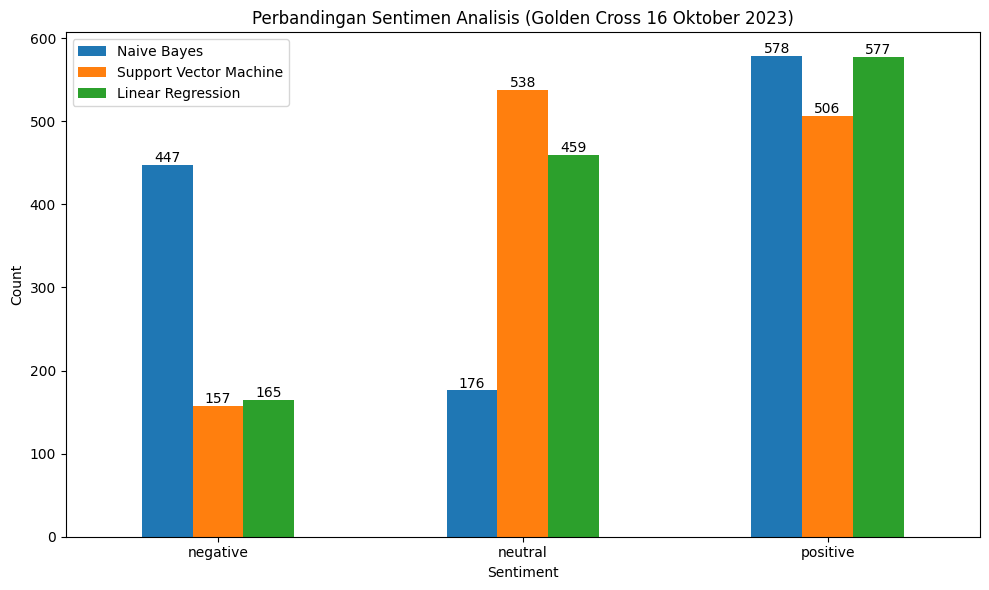

In [121]:
import matplotlib.pyplot as plt

sentiment_NB = data['Sentiment_NB_16_10_2023'].value_counts()
sentiment_SVM = data['Sentiment_SVM_16_10_2023'].value_counts()
sentiment_LR = data['Sentiment_LR_16_10_2023'].value_counts()

sentiment_combined = pd.DataFrame({
    'Naive Bayes': sentiment_NB,
    'Support Vector Machine': sentiment_SVM,
    'Linear Regression': sentiment_LR
})

ax = sentiment_combined.plot(kind='bar', figsize=(10, 6))
plt.title('Perbandingan Sentimen Analisis (Golden Cross 16 Oktober 2023)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()


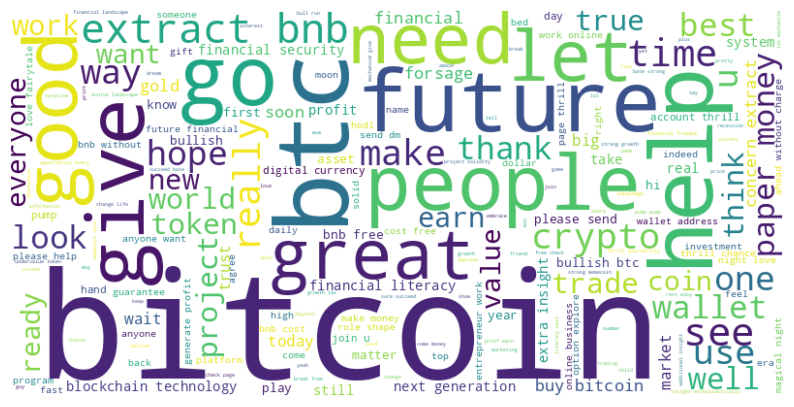

In [122]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan teks dari ketiga kolom
positive_text = ' '.join(data[data['Sentiment_NB_16_10_2023'] == 'positive']['End_Text']) + ' '
positive_text += ' '.join(data[data['Sentiment_SVM_16_10_2023'] == 'positive']['End_Text']) + ' '
positive_text += ' '.join(data[data['Sentiment_LR_16_10_2023'] == 'positive']['End_Text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

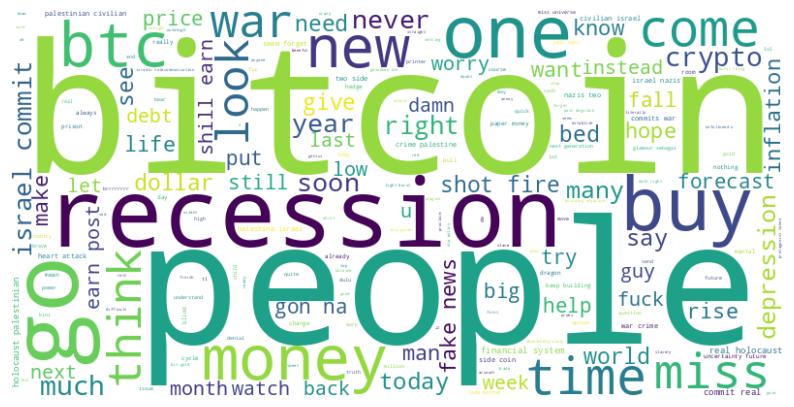

In [123]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan teks dari ketiga kolom
negative_text = ' '.join(data[data['Sentiment_NB_16_10_2023'] == 'negative']['End_Text']) + ' '
negative_text += ' '.join(data[data['Sentiment_SVM_16_10_2023'] == 'negative']['End_Text']) + ' '
negative_text += ' '.join(data[data['Sentiment_LR_16_10_2023'] == 'negative']['End_Text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

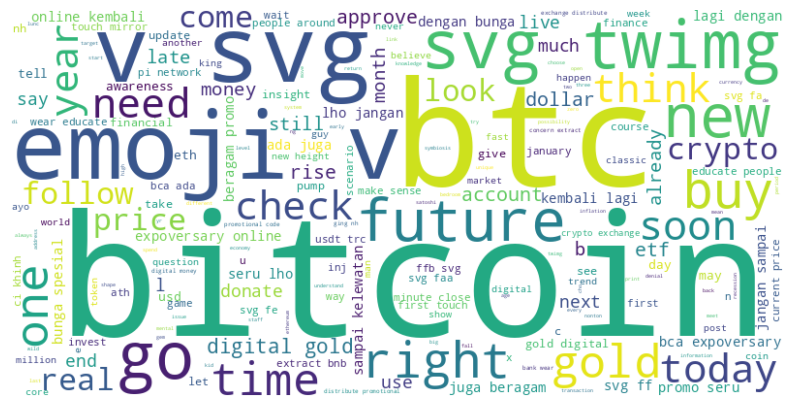

In [124]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan teks dari ketiga kolom
neutral_text = ' '.join(data[data['Sentiment_NB_16_10_2023'] == 'neutral']['End_Text']) + ' '
neutral_text += ' '.join(data[data['Sentiment_SVM_16_10_2023'] == 'neutral']['End_Text']) + ' '
neutral_text += ' '.join(data[data['Sentiment_LR_16_10_2023'] == 'neutral']['End_Text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# **Golden Cross 29 Januari 2024**

In [125]:
path ='/content/drive/MyDrive/Colab Notebooks/Dataset Penelitian/29 Januari 2024 Golden Cross/29 Januari 2024.xlsx'
data = pd.read_excel(path)
data

url                  name  \
0             https://twitter.com/Bitcoin               Bitcoin   
1           https://twitter.com/RichQuack             RichQuack   
2            https://twitter.com/Dobaggie          Golden Goose   
3     https://twitter.com/KayleeDaugher11      Kaylee Daugherty   
4     https://twitter.com/RandomCryptoPal     Random Crypto Pal   
...                                   ...                   ...   
2425     https://twitter.com/_Mubsharkhan          Mubshar Khan   
2426      https://twitter.com/shaurya12_5                   Sam   
2427   https://twitter.com/ThuyDung534712              ThuyDung   
2428  https://twitter.com/cleitonpedroAm2  cleiton pedro Amorim   
2429      https://twitter.com/kripto_blue           Kripto_blue   

              username                                               text  \
0             @Bitcoin                                           #Bitcoin   
1           @RichQuack  Wow, reaching new heights! Keep soaring, Bitcoin!   
2            @Dobaggie                                        Bullish for   
3     @KayleeDaugher11            I got a؜cc؜؜es؜s to the TENSET launcher   
4     @RandomCryptoPal                         Bitcoin pumping like crazy   
...                ...                                                ...   
2425     @_Mubsharkhan                                 I already told you   
2426      @shaurya12_5                            Convert in Rupees plzzz   
2427   @ThuyDung534712                 Wow, that's an impress⁤⁤ive value!   
2428  @cleitonpedroAm2                                  Buscando o aidrop   
2429      @kripto_blue                                 Merhaba ben geldim   

                   date                                   Cleaned_Text  \
0                   NaN                                        bitcoin   
1                Jan 28  wow reaching new heights keep soaring bitcoin   
2                Jan 28                                    bullish for   
3     From tensetio.com         i got a cc es s to the tenset launcher   
4                Jan 28                     bitcoin pumping like crazy   
...                 ...                                            ...   
2425              Feb 1                             i already told you   
2426              Feb 1                        convert in rupees plzzz   
2427              Feb 1                wow that s an impress ive value   
2428              Feb 1                              buscando o aidrop   
2429              Feb 2                             merhaba ben geldim   

                                           Tokenization  \
0                                           ['bitcoin']   
1     ['wow', 'reaching', 'new', 'heights', 'keep', ...   
2                                    ['bullish', 'for']   
3     ['i', 'got', 'a', 'cc', 'es', 's', 'to', 'the'...   
4               ['bitcoin', 'pumping', 'like', 'crazy']   
...                                                 ...   
2425                    ['i', 'already', 'told', 'you']   
2426               ['convert', 'in', 'rupees', 'plzzz']   
2427  ['wow', 'that', 's', 'an', 'impress', 'ive', '...   
2428                        ['buscando', 'o', 'aidrop']   
2429                       ['merhaba', 'ben', 'geldim']   

                                              Stopwords  \
0                                           ['bitcoin']   
1     ['wow', 'reaching', 'new', 'heights', 'keep', ...   
2                                           ['bullish']   
3             ['got', 'cc', 'es', 'tenset', 'launcher']   
4               ['bitcoin', 'pumping', 'like', 'crazy']   
...                                                 ...   
2425                                ['already', 'told']   
2426                     ['convert', 'rupees', 'plzzz']   
2427                 ['wow', 'impress', 'ive', 'value']   
2428                             ['buscando', 'aidrop']   
2429                       ['merhaba', 'ben', 'geldim']   

 

**Sentiment Naive Bayes**

In [126]:
data['End_Text'].fillna('', inplace=True)
new_text_vec = vectorizer.transform(data['End_Text'])
data['Sentiment_NB_29_01_2024'] = model_naive_bayes.predict(new_text_vec)

In [130]:
sentiment_counts = data['Sentiment_NB_29_01_2024'].value_counts()
total_samples = len(data)

print ("Data setiap sentimen")
print (sentiment_counts)

sentiment_percentages = (sentiment_counts / total_samples) * 100

print("Persentase setiap sentimen:")
print(sentiment_percentages)

Data setiap sentimen
Sentiment_NB_29_01_2024
positive    1341
negative     717
neutral      372
Name: count, dtype: int64
Persentase setiap sentimen:
Sentiment_NB_29_01_2024
positive    55.185185
negative    29.506173
neutral     15.308642
Name: count, dtype: float64


**Sentiment Support Vector Machine**

In [127]:
data['Sentiment_SVM_29_01_2024'] = model_svm.predict(new_text_vec)

In [132]:
sentiment_counts = data['Sentiment_SVM_29_01_2024'].value_counts()
total_samples = len(data)

print ("Data setiap sentimen")
print (sentiment_counts)

sentiment_percentages = (sentiment_counts / total_samples) * 100

print("Persentase setiap sentimen:")
print(sentiment_percentages)

Data setiap sentimen
Sentiment_SVM_29_01_2024
neutral     1108
positive    1094
negative     228
Name: count, dtype: int64
Persentase setiap sentimen:
Sentiment_SVM_29_01_2024
neutral     45.596708
positive    45.020576
negative     9.382716
Name: count, dtype: float64


**Sentiment Linear Regression**

In [128]:
data['Sentiment_LR_29_01_2024'] = model_linear_regression.predict(new_text_vec)

In [133]:
sentiment_counts = data['Sentiment_LR_29_01_2024'].value_counts()
total_samples = len(data)

print ("Data setiap sentimen")
print (sentiment_counts)

sentiment_percentages = (sentiment_counts / total_samples) * 100

print("Persentase setiap sentimen:")
print(sentiment_percentages)

Data setiap sentimen
Sentiment_LR_29_01_2024
positive    1226
neutral      972
negative     232
Name: count, dtype: int64
Persentase setiap sentimen:
Sentiment_LR_29_01_2024
positive    50.452675
neutral     40.000000
negative     9.547325
Name: count, dtype: float64


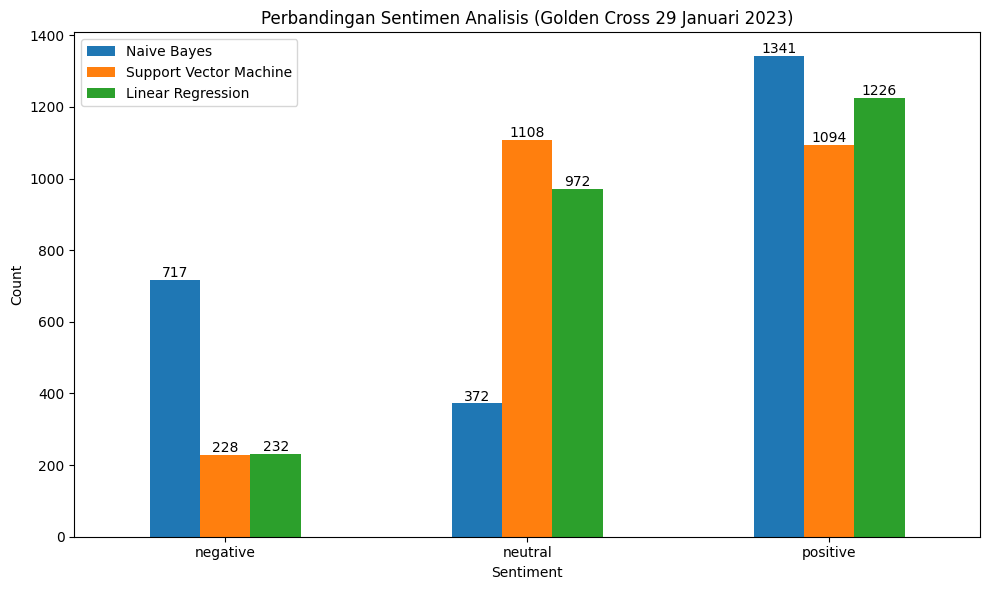

In [134]:
import matplotlib.pyplot as plt

sentiment_NB = data['Sentiment_NB_29_01_2024'].value_counts()
sentiment_SVM = data['Sentiment_SVM_29_01_2024'].value_counts()
sentiment_LR = data['Sentiment_LR_29_01_2024'].value_counts()

sentiment_combined = pd.DataFrame({
    'Naive Bayes': sentiment_NB,
    'Support Vector Machine': sentiment_SVM,
    'Linear Regression': sentiment_LR
})

ax = sentiment_combined.plot(kind='bar', figsize=(10, 6))
plt.title('Perbandingan Sentimen Analisis (Golden Cross 29 Januari 2023)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()


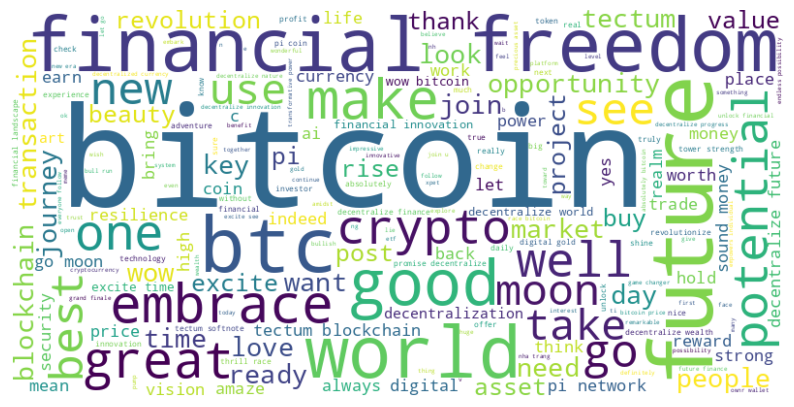

In [135]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan teks dari ketiga kolom
positive_text = ' '.join(data[data['Sentiment_NB_29_01_2024'] == 'positive']['End_Text']) + ' '
positive_text += ' '.join(data[data['Sentiment_SVM_29_01_2024'] == 'positive']['End_Text']) + ' '
positive_text += ' '.join(data[data['Sentiment_LR_29_01_2024'] == 'positive']['End_Text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

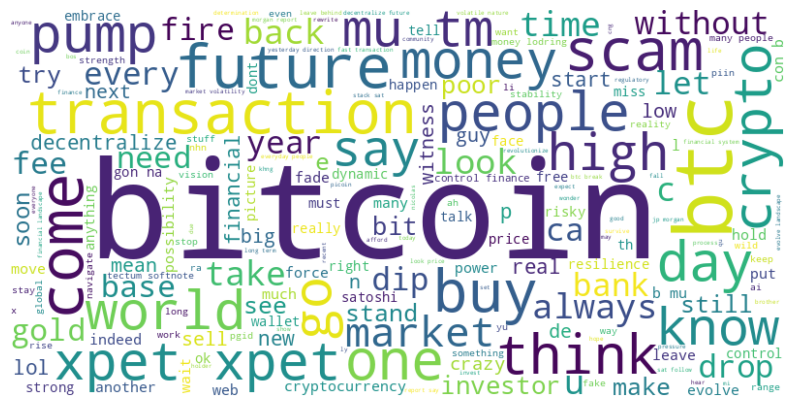

In [136]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan teks dari ketiga kolom
negative_text = ' '.join(data[data['Sentiment_NB_29_01_2024'] == 'negative']['End_Text']) + ' '
negative_text += ' '.join(data[data['Sentiment_SVM_29_01_2024'] == 'negative']['End_Text']) + ' '
negative_text += ' '.join(data[data['Sentiment_LR_29_01_2024'] == 'negative']['End_Text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

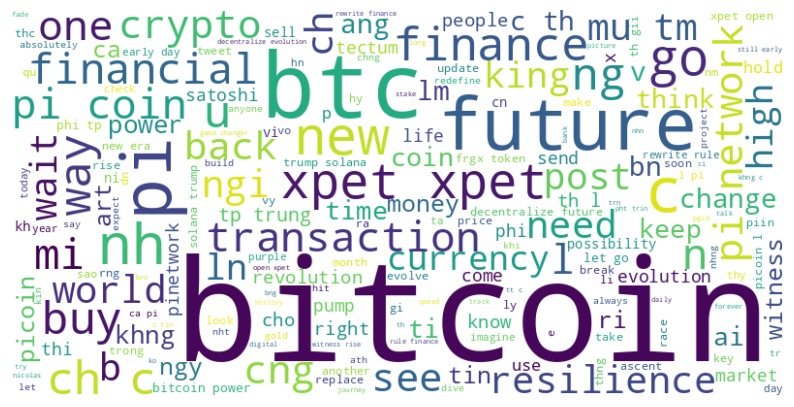

In [137]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan teks dari ketiga kolom
neutral_text = ' '.join(data[data['Sentiment_NB_29_01_2024'] == 'neutral']['End_Text']) + ' '
neutral_text += ' '.join(data[data['Sentiment_SVM_29_01_2024'] == 'neutral']['End_Text']) + ' '
neutral_text += ' '.join(data[data['Sentiment_LR_29_01_2024'] == 'neutral']['End_Text'])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()